In [1]:
colab = 1
if colab :
  from google.colab import drive
  drive.mount('/content/drive')
  %cd /content/drive/MyDrive/Github/Opti-Project/src/vision_experiments
  !pip install einops

Mounted at /content/drive
/content/drive/MyDrive/Github/Opti-Project/src/vision_experiments
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.5 MB/s eta 0:00:00


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import random
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
import functools
from torch.optim.lr_scheduler import LambdaLR
from functools import partial
from pathlib import Path
from PIL import Image
from train_utils import *
from plot_utils import *
from vit_small import *

In [4]:
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
#32 42 73
set_seed(42)

cuda:0


In [5]:
def train_eval_model(model, model_name, forward, optimizer, clip_val=0) :
    nb_epochs = 30
    input_size = train_loader.dataset[0][0].nelement()
    num_classes = 10
    model.to(device)
    print(model_name)
    k_value = 1e-4
    lr_lambda = functools.partial(exponential_lr_decay, k=k_value)
    scheduler = LambdaLR(optimizer, lr_lambda)
    #scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.05, patience=2, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)
    output_path = Path("visionModels_runs/forward/") if forward else Path("visionModels_runs/backward/")
    if forward :
      _, _, _, _, run_path = train_validate_forward(
        device,
        nb_epochs,
        model,
        model_name,
        input_size,
        train_loader,
        val_loader,
        optimizer,
        scheduler,
        output_path,
        gradient_clip_val=clip_val,
        flatten=False)
    else :
        _, _, _, _, run_path = train_validate_backward(
        device,
        nb_epochs,
        model,
        model_name,
        input_size,
        train_loader,
        val_loader,
        optimizer,
        scheduler,
        output_path,
        gradient_clip_val=clip_val,
        flatten=False)
    test_results = evaluate(device, model, input_size, test_loader, run_path=run_path, flatten=False)
    print("test results")
    print(test_results)

In [6]:
train_loader, val_loader, test_loader = get_data("CIFAR10", img_size=32)

Files already downloaded and verified
Files already downloaded and verified
Train dataset: 45000 batch size 64 of dim torch.Size([3, 32, 32])
Validation dataset: 5000 batch size 64 of dim torch.Size([3, 32, 32])
Test dataset: 10000 batch size 64 of dim torch.Size([3, 32, 32])


# Basic convnet

In [ ]:
class ConvNet(torch.nn.Module):
    def __init__(self, input_size: int = 1, output_size: int = 10):
        """Standard Convolutional Network layers.

        Args:
            input_size (int): input size of the model.
            output_size (int): The number of output classes.

        """
        super(ConvNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(input_size, 64, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv3 = torch.nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv4 = torch.nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.fc1 = torch.nn.Linear(4096, 1024)
        self.fc2 = torch.nn.Linear(1024, output_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## Backward

In [ ]:
model_name = "convnet"
model = ConvNet(input_size = 3, output_size= 10)
optimizer =  optim.Adam(model.parameters(),lr=2e-4, eps= 1e-4, weight_decay= 0.0)
train_eval_model(model, model_name, False, optimizer, clip_val=0)

convnet


	Validating: 100%|██████████| 79/79 [00:01<00:00, 46.00it/s, iters_per_sec=46, vacc=0.75, vf1=0.583, vloss=0.945]


Epoch 1 lr: 0.0002 Averages : Train Loss: 1.5021 Val Loss: 1.1792 Train Acc: 0.4606 Val Acc: 0.5710 Train F1: 0.4277 Val F1: 0.5394
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 45.83it/s, iters_per_sec=45.8, vacc=0.75, vf1=0.63, vloss=0.75]


Epoch 2 lr: 0.00019998000099996668 Averages : Train Loss: 1.0628 Val Loss: 0.9650 Train Acc: 0.6252 Val Acc: 0.6549 Train F1: 0.5997 Val F1: 0.6347
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 44.85it/s, iters_per_sec=44.8, vacc=0.625, vf1=0.333, vloss=0.673]


Epoch 3 lr: 0.00019996000399973335 Averages : Train Loss: 0.8456 Val Loss: 0.8853 Train Acc: 0.7020 Val Acc: 0.6816 Train F1: 0.6823 Val F1: 0.6562
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 45.15it/s, iters_per_sec=45.1, vacc=0.75, vf1=0.686, vloss=0.529]


Epoch 4 lr: 0.0001999400089991001 Averages : Train Loss: 0.6905 Val Loss: 0.8180 Train Acc: 0.7598 Val Acc: 0.7170 Train F1: 0.7413 Val F1: 0.6965
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 45.42it/s, iters_per_sec=45.4, vacc=0.75, vf1=0.762, vloss=0.563]


Epoch 5 lr: 0.0001999200159978669 Averages : Train Loss: 0.5424 Val Loss: 0.7735 Train Acc: 0.8122 Val Acc: 0.7338 Train F1: 0.7977 Val F1: 0.7137
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 45.47it/s, iters_per_sec=45.4, vacc=0.5, vf1=0.476, vloss=2.01]


Epoch 6 lr: 0.00019990002499583386 Averages : Train Loss: 0.3929 Val Loss: 0.7981 Train Acc: 0.8647 Val Acc: 0.7456 Train F1: 0.8527 Val F1: 0.7229


	Validating: 100%|██████████| 79/79 [00:01<00:00, 45.60it/s, iters_per_sec=45.6, vacc=0.625, vf1=0.595, vloss=0.944]


Epoch 7 lr: 0.0001998800359928011 Averages : Train Loss: 0.2462 Val Loss: 0.8821 Train Acc: 0.9176 Val Acc: 0.7306 Train F1: 0.9101 Val F1: 0.7109


	Validating: 100%|██████████| 79/79 [00:01<00:00, 46.41it/s, iters_per_sec=46.4, vacc=0.875, vf1=0.905, vloss=0.887]


Epoch 8 lr: 0.00019986004898856868 Averages : Train Loss: 0.1395 Val Loss: 1.0358 Train Acc: 0.9550 Val Acc: 0.7373 Train F1: 0.9502 Val F1: 0.7212


	Validating: 100%|██████████| 79/79 [00:01<00:00, 44.02it/s, iters_per_sec=44, vacc=0.75, vf1=0.571, vloss=1.1]


Epoch 9 lr: 0.00019984006398293674 Averages : Train Loss: 0.0829 Val Loss: 1.1462 Train Acc: 0.9737 Val Acc: 0.7439 Train F1: 0.9709 Val F1: 0.7235


	Validating: 100%|██████████| 79/79 [00:01<00:00, 45.84it/s, iters_per_sec=45.8, vacc=0.875, vf1=0.75, vloss=0.485]


Epoch 10 lr: 0.0001998200809757055 Averages : Train Loss: 0.0610 Val Loss: 1.2799 Train Acc: 0.9805 Val Acc: 0.7211 Train F1: 0.9784 Val F1: 0.7024


	Validating: 100%|██████████| 79/79 [00:01<00:00, 44.67it/s, iters_per_sec=44.6, vacc=0.75, vf1=0.722, vloss=4.1]


Epoch 11 lr: 0.00019980009996667503 Averages : Train Loss: 0.0517 Val Loss: 1.3619 Train Acc: 0.9833 Val Acc: 0.7421 Train F1: 0.9815 Val F1: 0.7242


	Validating: 100%|██████████| 79/79 [00:01<00:00, 45.78it/s, iters_per_sec=45.8, vacc=0.875, vf1=0.667, vloss=1.48]


Epoch 12 lr: 0.00019978012095564553 Averages : Train Loss: 0.0462 Val Loss: 1.4159 Train Acc: 0.9852 Val Acc: 0.7395 Train F1: 0.9830 Val F1: 0.7204


	Validating: 100%|██████████| 79/79 [00:01<00:00, 45.90it/s, iters_per_sec=45.9, vacc=0.875, vf1=0.714, vloss=0.353]


Epoch 13 lr: 0.00019976014394241728 Averages : Train Loss: 0.0364 Val Loss: 1.5225 Train Acc: 0.9881 Val Acc: 0.7328 Train F1: 0.9867 Val F1: 0.7142


	Validating: 100%|██████████| 79/79 [00:01<00:00, 45.60it/s, iters_per_sec=45.6, vacc=0.5, vf1=0.407, vloss=1.63]


Epoch 14 lr: 0.00019974016892679045 Averages : Train Loss: 0.0375 Val Loss: 1.4919 Train Acc: 0.9875 Val Acc: 0.7348 Train F1: 0.9864 Val F1: 0.7121


	Validating: 100%|██████████| 79/79 [00:01<00:00, 46.24it/s, iters_per_sec=46.2, vacc=0.625, vf1=0.448, vloss=2.51]


Epoch 15 lr: 0.00019972019590856535 Averages : Train Loss: 0.0379 Val Loss: 1.5263 Train Acc: 0.9880 Val Acc: 0.7377 Train F1: 0.9872 Val F1: 0.7172


	Validating: 100%|██████████| 79/79 [00:01<00:00, 45.20it/s, iters_per_sec=45.2, vacc=0.625, vf1=0.411, vloss=0.855]


Epoch 16 lr: 0.00019970022488754218 Averages : Train Loss: 0.0277 Val Loss: 1.5841 Train Acc: 0.9908 Val Acc: 0.7344 Train F1: 0.9899 Val F1: 0.7185


	Validating: 100%|██████████| 79/79 [00:01<00:00, 46.01it/s, iters_per_sec=46, vacc=0.625, vf1=0.458, vloss=3.03]


Epoch 17 lr: 0.00019968025586352127 Averages : Train Loss: 0.0273 Val Loss: 1.6929 Train Acc: 0.9916 Val Acc: 0.7261 Train F1: 0.9904 Val F1: 0.7080


	Validating: 100%|██████████| 79/79 [00:01<00:00, 45.77it/s, iters_per_sec=45.7, vacc=0.625, vf1=0.481, vloss=4.18]


Epoch 18 lr: 0.00019966028883630293 Averages : Train Loss: 0.0296 Val Loss: 1.6186 Train Acc: 0.9913 Val Acc: 0.7350 Train F1: 0.9905 Val F1: 0.7173


	Validating: 100%|██████████| 79/79 [00:01<00:00, 45.59it/s, iters_per_sec=45.6, vacc=0.625, vf1=0.524, vloss=2.06]


Epoch 19 lr: 0.00019964032380568746 Averages : Train Loss: 0.0228 Val Loss: 1.7351 Train Acc: 0.9924 Val Acc: 0.7229 Train F1: 0.9915 Val F1: 0.6981


	Validating: 100%|██████████| 79/79 [00:01<00:00, 45.12it/s, iters_per_sec=45.1, vacc=0.75, vf1=0.638, vloss=0.449]


Epoch 20 lr: 0.00019962036077147524 Averages : Train Loss: 0.0238 Val Loss: 1.7959 Train Acc: 0.9919 Val Acc: 0.7348 Train F1: 0.9909 Val F1: 0.7098


	Validating: 100%|██████████| 79/79 [00:01<00:00, 45.91it/s, iters_per_sec=45.9, vacc=0.875, vf1=0.733, vloss=0.267]


Epoch 21 lr: 0.00019960039973346662 Averages : Train Loss: 0.0253 Val Loss: 1.6486 Train Acc: 0.9913 Val Acc: 0.7407 Train F1: 0.9904 Val F1: 0.7217


	Validating: 100%|██████████| 79/79 [00:01<00:00, 46.78it/s, iters_per_sec=46.8, vacc=0.5, vf1=0.381, vloss=2.55]


Epoch 22 lr: 0.000199580440691462 Averages : Train Loss: 0.0203 Val Loss: 1.7381 Train Acc: 0.9937 Val Acc: 0.7441 Train F1: 0.9928 Val F1: 0.7247


	Validating: 100%|██████████| 79/79 [00:01<00:00, 44.37it/s, iters_per_sec=44.3, vacc=0.75, vf1=0.694, vloss=0.585]


Epoch 23 lr: 0.0001995604836452618 Averages : Train Loss: 0.0196 Val Loss: 1.8574 Train Acc: 0.9930 Val Acc: 0.7360 Train F1: 0.9922 Val F1: 0.7187


	Validating: 100%|██████████| 79/79 [00:01<00:00, 46.41it/s, iters_per_sec=46.4, vacc=0.875, vf1=0.75, vloss=0.65]


Epoch 24 lr: 0.00019954052859466644 Averages : Train Loss: 0.0222 Val Loss: 1.7505 Train Acc: 0.9932 Val Acc: 0.7371 Train F1: 0.9924 Val F1: 0.7179


	Validating: 100%|██████████| 79/79 [00:01<00:00, 45.34it/s, iters_per_sec=45.3, vacc=0.5, vf1=0.511, vloss=2.7]


Epoch 25 lr: 0.00019952057553947636 Averages : Train Loss: 0.0245 Val Loss: 1.8458 Train Acc: 0.9921 Val Acc: 0.7356 Train F1: 0.9909 Val F1: 0.7140


	Validating: 100%|██████████| 79/79 [00:01<00:00, 44.51it/s, iters_per_sec=44.5, vacc=0.75, vf1=0.583, vloss=3.23]


Epoch 26 lr: 0.000199500624479492 Averages : Train Loss: 0.0138 Val Loss: 1.8532 Train Acc: 0.9957 Val Acc: 0.7401 Train F1: 0.9954 Val F1: 0.7168


	Validating: 100%|██████████| 79/79 [00:01<00:00, 44.77it/s, iters_per_sec=44.8, vacc=0.625, vf1=0.422, vloss=1.34]


Epoch 27 lr: 0.00019948067541451396 Averages : Train Loss: 0.0172 Val Loss: 1.7691 Train Acc: 0.9944 Val Acc: 0.7389 Train F1: 0.9939 Val F1: 0.7176


	Validating: 100%|██████████| 79/79 [00:01<00:00, 45.81it/s, iters_per_sec=45.8, vacc=0.75, vf1=0.524, vloss=1.86]


Epoch 28 lr: 0.00019946072834434265 Averages : Train Loss: 0.0160 Val Loss: 1.9269 Train Acc: 0.9948 Val Acc: 0.7405 Train F1: 0.9943 Val F1: 0.7165


	Validating: 100%|██████████| 79/79 [00:01<00:00, 44.74it/s, iters_per_sec=44.7, vacc=0.625, vf1=0.444, vloss=1.25]


Epoch 29 lr: 0.0001994407832687786 Averages : Train Loss: 0.0186 Val Loss: 1.8629 Train Acc: 0.9937 Val Acc: 0.7387 Train F1: 0.9933 Val F1: 0.7219


	Validating: 100%|██████████| 79/79 [00:01<00:00, 46.23it/s, iters_per_sec=46.2, vacc=0.625, vf1=0.548, vloss=2.32]


Epoch 30 lr: 0.0001994208401876224 Averages : Train Loss: 0.0178 Val Loss: 1.9413 Train Acc: 0.9941 Val Acc: 0.7364 Train F1: 0.9934 Val F1: 0.7168


	Evaluating: 100%|██████████| 157/157 [00:03<00:00, 45.70it/s, eval_acc=0.75, eval_f1=0.606, iters_per_sec=45.7]


test results
{'Acc': 0.7378582802547771, 'F1': 0.7177551995248344}


## Forward

In [ ]:
model_name = "convnet"
model = ConvNet(input_size = 3, output_size= 10)
optimizer =  optim.Adam(model.parameters(),lr=2e-4, eps= 1e-4, weight_decay= 0.0)
train_eval_model(model, model_name, True, optimizer, clip_val=0)

convnet


	Validating: 100%|██████████| 79/79 [00:01<00:00, 43.62it/s, iters_per_sec=43.6, vacc=0, vf1=0, vloss=2.3]


Epoch 1 lr: 0.0002 Averages : Train Loss: 2.3015 Val Loss: 2.3006 Train Acc: 0.1010 Val Acc: 0.0977 Train F1: 0.0452 Val F1: 0.0375
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 44.56it/s, iters_per_sec=44.5, vacc=0.25, vf1=0.0667, vloss=2.28]


Epoch 2 lr: 0.00019998000099996668 Averages : Train Loss: 2.2981 Val Loss: 2.2962 Train Acc: 0.1184 Val Acc: 0.1224 Train F1: 0.0596 Val F1: 0.0575
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 45.72it/s, iters_per_sec=45.7, vacc=0.375, vf1=0.109, vloss=2.25]


Epoch 3 lr: 0.00019996000399973335 Averages : Train Loss: 2.2930 Val Loss: 2.2898 Train Acc: 0.1409 Val Acc: 0.1367 Train F1: 0.0747 Val F1: 0.0672
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 44.17it/s, iters_per_sec=44.1, vacc=0.125, vf1=0.0952, vloss=2.25]


Epoch 4 lr: 0.0001999400089991001 Averages : Train Loss: 2.2835 Val Loss: 2.2764 Train Acc: 0.1641 Val Acc: 0.1588 Train F1: 0.0898 Val F1: 0.0793
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 45.56it/s, iters_per_sec=45.5, vacc=0.125, vf1=0.0417, vloss=2.27]


Epoch 5 lr: 0.0001999200159978669 Averages : Train Loss: 2.2649 Val Loss: 2.2538 Train Acc: 0.1752 Val Acc: 0.1612 Train F1: 0.0942 Val F1: 0.0853
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 44.40it/s, iters_per_sec=44.3, vacc=0.5, vf1=0.352, vloss=2.1]


Epoch 6 lr: 0.00019990002499583386 Averages : Train Loss: 2.2350 Val Loss: 2.2222 Train Acc: 0.1799 Val Acc: 0.1903 Train F1: 0.1051 Val F1: 0.1266
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 44.82it/s, iters_per_sec=44.8, vacc=0.125, vf1=0.0833, vloss=2.22]


Epoch 7 lr: 0.0001998800359928011 Averages : Train Loss: 2.1955 Val Loss: 2.1815 Train Acc: 0.2102 Val Acc: 0.2352 Train F1: 0.1531 Val F1: 0.1912
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 45.45it/s, iters_per_sec=45.4, vacc=0.5, vf1=0.452, vloss=2.05]


Epoch 8 lr: 0.00019986004898856868 Averages : Train Loss: 2.1620 Val Loss: 2.1579 Train Acc: 0.2394 Val Acc: 0.2342 Train F1: 0.1923 Val F1: 0.1871
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 45.22it/s, iters_per_sec=45.2, vacc=0.375, vf1=0.25, vloss=2.15]


Epoch 9 lr: 0.00019984006398293674 Averages : Train Loss: 2.1384 Val Loss: 2.1345 Train Acc: 0.2412 Val Acc: 0.2411 Train F1: 0.1950 Val F1: 0.1989
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 43.83it/s, iters_per_sec=43.8, vacc=0.25, vf1=0.146, vloss=2.09]


Epoch 10 lr: 0.0001998200809757055 Averages : Train Loss: 2.1166 Val Loss: 2.1160 Train Acc: 0.2443 Val Acc: 0.2427 Train F1: 0.2024 Val F1: 0.1984
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 44.92it/s, iters_per_sec=44.9, vacc=0.25, vf1=0.13, vloss=2.02]


Epoch 11 lr: 0.00019980009996667503 Averages : Train Loss: 2.0989 Val Loss: 2.0981 Train Acc: 0.2467 Val Acc: 0.2470 Train F1: 0.2030 Val F1: 0.1998
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 44.21it/s, iters_per_sec=44.2, vacc=0.375, vf1=0.31, vloss=2.01]


Epoch 12 lr: 0.00019978012095564553 Averages : Train Loss: 2.0795 Val Loss: 2.0815 Train Acc: 0.2575 Val Acc: 0.2601 Train F1: 0.2168 Val F1: 0.2238
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 46.28it/s, iters_per_sec=46.3, vacc=0.25, vf1=0.129, vloss=1.98]


Epoch 13 lr: 0.00019976014394241728 Averages : Train Loss: 2.0645 Val Loss: 2.0674 Train Acc: 0.2647 Val Acc: 0.2565 Train F1: 0.2281 Val F1: 0.2149
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 45.67it/s, iters_per_sec=45.6, vacc=0.25, vf1=0.0833, vloss=2.2]


Epoch 14 lr: 0.00019974016892679045 Averages : Train Loss: 2.0514 Val Loss: 2.0566 Train Acc: 0.2640 Val Acc: 0.2680 Train F1: 0.2218 Val F1: 0.2286
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 44.86it/s, iters_per_sec=44.8, vacc=0.125, vf1=0.0625, vloss=2.24]


Epoch 15 lr: 0.00019972019590856535 Averages : Train Loss: 2.0410 Val Loss: 2.0559 Train Acc: 0.2695 Val Acc: 0.2670 Train F1: 0.2306 Val F1: 0.2288
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 45.13it/s, iters_per_sec=45.1, vacc=0.25, vf1=0.19, vloss=2]


Epoch 16 lr: 0.00019970022488754218 Averages : Train Loss: 2.0386 Val Loss: 2.0515 Train Acc: 0.2741 Val Acc: 0.2714 Train F1: 0.2324 Val F1: 0.2310
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 44.99it/s, iters_per_sec=45, vacc=0, vf1=0, vloss=1.93]


Epoch 17 lr: 0.00019968025586352127 Averages : Train Loss: 2.0328 Val Loss: 2.0389 Train Acc: 0.2787 Val Acc: 0.2741 Train F1: 0.2389 Val F1: 0.2405
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 44.00it/s, iters_per_sec=44, vacc=0.25, vf1=0.2, vloss=2.13]


Epoch 18 lr: 0.00019966028883630293 Averages : Train Loss: 2.0252 Val Loss: 2.0399 Train Acc: 0.2800 Val Acc: 0.2700 Train F1: 0.2359 Val F1: 0.2277


	Validating: 100%|██████████| 79/79 [00:01<00:00, 45.69it/s, iters_per_sec=45.7, vacc=0.25, vf1=0.146, vloss=2.11]


Epoch 19 lr: 0.00019964032380568746 Averages : Train Loss: 2.0192 Val Loss: 2.0257 Train Acc: 0.2791 Val Acc: 0.2812 Train F1: 0.2381 Val F1: 0.2402
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 45.22it/s, iters_per_sec=45.2, vacc=0.25, vf1=0.222, vloss=1.75]


Epoch 20 lr: 0.00019962036077147524 Averages : Train Loss: 2.0091 Val Loss: 2.0227 Train Acc: 0.2878 Val Acc: 0.2753 Train F1: 0.2530 Val F1: 0.2455
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 44.79it/s, iters_per_sec=44.8, vacc=0.25, vf1=0.152, vloss=1.98]


Epoch 21 lr: 0.00019960039973346662 Averages : Train Loss: 2.0101 Val Loss: 2.0283 Train Acc: 0.2822 Val Acc: 0.2674 Train F1: 0.2511 Val F1: 0.2332


	Validating: 100%|██████████| 79/79 [00:01<00:00, 45.66it/s, iters_per_sec=45.6, vacc=0.125, vf1=0.0408, vloss=2.34]


Epoch 22 lr: 0.000199580440691462 Averages : Train Loss: 2.0021 Val Loss: 2.0180 Train Acc: 0.2831 Val Acc: 0.2739 Train F1: 0.2486 Val F1: 0.2380
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 43.91it/s, iters_per_sec=43.9, vacc=0.375, vf1=0.144, vloss=1.98]


Epoch 23 lr: 0.0001995604836452618 Averages : Train Loss: 1.9874 Val Loss: 2.0014 Train Acc: 0.2922 Val Acc: 0.2848 Train F1: 0.2593 Val F1: 0.2463
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 45.59it/s, iters_per_sec=45.6, vacc=0.625, vf1=0.5, vloss=1.82]


Epoch 24 lr: 0.00019954052859466644 Averages : Train Loss: 1.9796 Val Loss: 1.9968 Train Acc: 0.2922 Val Acc: 0.2832 Train F1: 0.2535 Val F1: 0.2461
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 44.18it/s, iters_per_sec=44.1, vacc=0.25, vf1=0.222, vloss=1.93]


Epoch 25 lr: 0.00019952057553947636 Averages : Train Loss: 1.9744 Val Loss: 1.9870 Train Acc: 0.2889 Val Acc: 0.2781 Train F1: 0.2540 Val F1: 0.2466
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 45.33it/s, iters_per_sec=45.3, vacc=0.375, vf1=0.333, vloss=1.61]


Epoch 26 lr: 0.000199500624479492 Averages : Train Loss: 1.9668 Val Loss: 1.9769 Train Acc: 0.2931 Val Acc: 0.2822 Train F1: 0.2605 Val F1: 0.2514
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 45.20it/s, iters_per_sec=45.2, vacc=0.125, vf1=0.111, vloss=2.13]


Epoch 27 lr: 0.00019948067541451396 Averages : Train Loss: 1.9631 Val Loss: 1.9871 Train Acc: 0.2972 Val Acc: 0.2822 Train F1: 0.2659 Val F1: 0.2500


	Validating: 100%|██████████| 79/79 [00:01<00:00, 45.14it/s, iters_per_sec=45.1, vacc=0.375, vf1=0.3, vloss=1.87]


Epoch 28 lr: 0.00019946072834434265 Averages : Train Loss: 1.9642 Val Loss: 1.9754 Train Acc: 0.2996 Val Acc: 0.2979 Train F1: 0.2694 Val F1: 0.2644
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 45.61it/s, iters_per_sec=45.6, vacc=0.25, vf1=0.167, vloss=2.16]


Epoch 29 lr: 0.0001994407832687786 Averages : Train Loss: 1.9628 Val Loss: 1.9774 Train Acc: 0.2978 Val Acc: 0.2834 Train F1: 0.2702 Val F1: 0.2601


	Validating: 100%|██████████| 79/79 [00:01<00:00, 45.91it/s, iters_per_sec=45.9, vacc=0.625, vf1=0.521, vloss=1.67]


Epoch 30 lr: 0.0001994208401876224 Averages : Train Loss: 1.9590 Val Loss: 1.9702 Train Acc: 0.3003 Val Acc: 0.2955 Train F1: 0.2725 Val F1: 0.2660
Best model saved


	Evaluating: 100%|██████████| 157/157 [00:03<00:00, 45.26it/s, eval_acc=0.438, eval_f1=0.274, iters_per_sec=45.3]

test results
{'Acc': 0.30642914012738853, 'F1': 0.27431730647792685}


In [ ]:
model_name = "convnet"
model = ConvNet(input_size = 3, output_size= 10)
optimizer =  optim.Adam(model.parameters(),lr=2e-4, eps= 1e-4, weight_decay= 0.0)
train_eval_model(model, model_name, True, optimizer, clip_val=5)

convnet


	Validating: 100%|██████████| 79/79 [00:01<00:00, 45.95it/s, iters_per_sec=45.9, vacc=0, vf1=0, vloss=2.29]


Epoch 1 lr: 0.0002 Averages : Train Loss: 2.3015 Val Loss: 2.2997 Train Acc: 0.1139 Val Acc: 0.1060 Train F1: 0.0449 Val F1: 0.0335
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 45.11it/s, iters_per_sec=45.1, vacc=0.375, vf1=0.171, vloss=2.29]


Epoch 2 lr: 0.00019998000099996668 Averages : Train Loss: 2.2990 Val Loss: 2.2975 Train Acc: 0.1136 Val Acc: 0.1345 Train F1: 0.0437 Val F1: 0.0561
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 44.96it/s, iters_per_sec=44.9, vacc=0.125, vf1=0.0833, vloss=2.3]


Epoch 3 lr: 0.00019996000399973335 Averages : Train Loss: 2.2954 Val Loss: 2.2933 Train Acc: 0.1382 Val Acc: 0.1416 Train F1: 0.0701 Val F1: 0.0759
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 44.22it/s, iters_per_sec=44.2, vacc=0, vf1=0, vloss=2.26]


Epoch 4 lr: 0.0001999400089991001 Averages : Train Loss: 2.2900 Val Loss: 2.2855 Train Acc: 0.1466 Val Acc: 0.1489 Train F1: 0.0756 Val F1: 0.0650
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 44.73it/s, iters_per_sec=44.7, vacc=0.25, vf1=0.15, vloss=2.29]


Epoch 5 lr: 0.0001999200159978669 Averages : Train Loss: 2.2830 Val Loss: 2.2811 Train Acc: 0.1507 Val Acc: 0.1313 Train F1: 0.0815 Val F1: 0.0678
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 44.73it/s, iters_per_sec=44.7, vacc=0.125, vf1=0.037, vloss=2.3]


Epoch 6 lr: 0.00019990002499583386 Averages : Train Loss: 2.2758 Val Loss: 2.2712 Train Acc: 0.1340 Val Acc: 0.1386 Train F1: 0.0725 Val F1: 0.0753
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 44.02it/s, iters_per_sec=44, vacc=0, vf1=0, vloss=2.23]


Epoch 7 lr: 0.0001998800359928011 Averages : Train Loss: 2.2632 Val Loss: 2.2552 Train Acc: 0.1629 Val Acc: 0.1725 Train F1: 0.0972 Val F1: 0.1101
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 45.05it/s, iters_per_sec=45, vacc=0.25, vf1=0.119, vloss=2.18]


Epoch 8 lr: 0.00019986004898856868 Averages : Train Loss: 2.2462 Val Loss: 2.2413 Train Acc: 0.1757 Val Acc: 0.1739 Train F1: 0.1240 Val F1: 0.1313
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 45.56it/s, iters_per_sec=45.5, vacc=0.25, vf1=0.152, vloss=2.26]


Epoch 9 lr: 0.00019984006398293674 Averages : Train Loss: 2.2305 Val Loss: 2.2225 Train Acc: 0.1943 Val Acc: 0.2148 Train F1: 0.1516 Val F1: 0.1772
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 45.43it/s, iters_per_sec=45.4, vacc=0.25, vf1=0.146, vloss=2.15]


Epoch 10 lr: 0.0001998200809757055 Averages : Train Loss: 2.2104 Val Loss: 2.2052 Train Acc: 0.2176 Val Acc: 0.2095 Train F1: 0.1782 Val F1: 0.1708
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 45.90it/s, iters_per_sec=45.9, vacc=0.25, vf1=0.152, vloss=2.25]


Epoch 11 lr: 0.00019980009996667503 Averages : Train Loss: 2.1941 Val Loss: 2.1918 Train Acc: 0.2292 Val Acc: 0.2267 Train F1: 0.1885 Val F1: 0.1858
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 44.69it/s, iters_per_sec=44.7, vacc=0.375, vf1=0.262, vloss=2.13]


Epoch 12 lr: 0.00019978012095564553 Averages : Train Loss: 2.1795 Val Loss: 2.1794 Train Acc: 0.2293 Val Acc: 0.2267 Train F1: 0.1917 Val F1: 0.1976
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 43.51it/s, iters_per_sec=43.5, vacc=0.125, vf1=0.0625, vloss=2.08]


Epoch 13 lr: 0.00019976014394241728 Averages : Train Loss: 2.1655 Val Loss: 2.1646 Train Acc: 0.2444 Val Acc: 0.2354 Train F1: 0.2145 Val F1: 0.1981
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 45.30it/s, iters_per_sec=45.3, vacc=0.375, vf1=0.25, vloss=2.13]


Epoch 14 lr: 0.00019974016892679045 Averages : Train Loss: 2.1526 Val Loss: 2.1524 Train Acc: 0.2465 Val Acc: 0.2342 Train F1: 0.2126 Val F1: 0.2022
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 45.40it/s, iters_per_sec=45.4, vacc=0.125, vf1=0.05, vloss=2.08]


Epoch 15 lr: 0.00019972019590856535 Averages : Train Loss: 2.1386 Val Loss: 2.1414 Train Acc: 0.2460 Val Acc: 0.2360 Train F1: 0.2118 Val F1: 0.1980
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 43.46it/s, iters_per_sec=43.4, vacc=0, vf1=0, vloss=2.1]


Epoch 16 lr: 0.00019970022488754218 Averages : Train Loss: 2.1229 Val Loss: 2.1235 Train Acc: 0.2499 Val Acc: 0.2472 Train F1: 0.2176 Val F1: 0.2183
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 45.74it/s, iters_per_sec=45.7, vacc=0.25, vf1=0.13, vloss=2.12]


Epoch 17 lr: 0.00019968025586352127 Averages : Train Loss: 2.1093 Val Loss: 2.1149 Train Acc: 0.2593 Val Acc: 0.2524 Train F1: 0.2324 Val F1: 0.2246
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 44.80it/s, iters_per_sec=44.8, vacc=0.375, vf1=0.312, vloss=1.94]


Epoch 18 lr: 0.00019966028883630293 Averages : Train Loss: 2.1004 Val Loss: 2.1046 Train Acc: 0.2591 Val Acc: 0.2532 Train F1: 0.2274 Val F1: 0.2181
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 45.13it/s, iters_per_sec=45.1, vacc=0.375, vf1=0.286, vloss=1.92]


Epoch 19 lr: 0.00019964032380568746 Averages : Train Loss: 2.0954 Val Loss: 2.1005 Train Acc: 0.2511 Val Acc: 0.2367 Train F1: 0.2149 Val F1: 0.1886
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 45.63it/s, iters_per_sec=45.6, vacc=0.5, vf1=0.417, vloss=1.75]


Epoch 20 lr: 0.00019962036077147524 Averages : Train Loss: 2.0812 Val Loss: 2.0851 Train Acc: 0.2591 Val Acc: 0.2601 Train F1: 0.2248 Val F1: 0.2272
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 45.10it/s, iters_per_sec=45.1, vacc=0.375, vf1=0.238, vloss=1.98]


Epoch 21 lr: 0.00019960039973346662 Averages : Train Loss: 2.0740 Val Loss: 2.0794 Train Acc: 0.2619 Val Acc: 0.2534 Train F1: 0.2275 Val F1: 0.2268
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 45.14it/s, iters_per_sec=45.1, vacc=0.125, vf1=0.0571, vloss=2.19]


Epoch 22 lr: 0.000199580440691462 Averages : Train Loss: 2.0682 Val Loss: 2.0785 Train Acc: 0.2658 Val Acc: 0.2611 Train F1: 0.2378 Val F1: 0.2309
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 45.26it/s, iters_per_sec=45.2, vacc=0.125, vf1=0.143, vloss=2.07]


Epoch 23 lr: 0.0001995604836452618 Averages : Train Loss: 2.0621 Val Loss: 2.0762 Train Acc: 0.2643 Val Acc: 0.2498 Train F1: 0.2328 Val F1: 0.2201
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 44.43it/s, iters_per_sec=44.4, vacc=0.125, vf1=0.0714, vloss=2.04]


Epoch 24 lr: 0.00019954052859466644 Averages : Train Loss: 2.0597 Val Loss: 2.0686 Train Acc: 0.2640 Val Acc: 0.2528 Train F1: 0.2355 Val F1: 0.2277
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 45.29it/s, iters_per_sec=45.3, vacc=0.125, vf1=0.0833, vloss=2.04]


Epoch 25 lr: 0.00019952057553947636 Averages : Train Loss: 2.0541 Val Loss: 2.0666 Train Acc: 0.2620 Val Acc: 0.2462 Train F1: 0.2349 Val F1: 0.2175
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 45.20it/s, iters_per_sec=45.2, vacc=0.25, vf1=0.133, vloss=2.17]


Epoch 26 lr: 0.000199500624479492 Averages : Train Loss: 2.0493 Val Loss: 2.0608 Train Acc: 0.2580 Val Acc: 0.2549 Train F1: 0.2266 Val F1: 0.2257
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 45.96it/s, iters_per_sec=45.9, vacc=0.25, vf1=0.148, vloss=2.05]


Epoch 27 lr: 0.00019948067541451396 Averages : Train Loss: 2.0435 Val Loss: 2.0580 Train Acc: 0.2661 Val Acc: 0.2474 Train F1: 0.2363 Val F1: 0.2117
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 44.75it/s, iters_per_sec=44.7, vacc=0.25, vf1=0.114, vloss=2.21]


Epoch 28 lr: 0.00019946072834434265 Averages : Train Loss: 2.0382 Val Loss: 2.0538 Train Acc: 0.2671 Val Acc: 0.2591 Train F1: 0.2363 Val F1: 0.2313
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 44.66it/s, iters_per_sec=44.6, vacc=0.125, vf1=0.0667, vloss=2.51]


Epoch 29 lr: 0.0001994407832687786 Averages : Train Loss: 2.0342 Val Loss: 2.0564 Train Acc: 0.2750 Val Acc: 0.2633 Train F1: 0.2474 Val F1: 0.2366


	Validating: 100%|██████████| 79/79 [00:01<00:00, 45.89it/s, iters_per_sec=45.9, vacc=0.375, vf1=0.3, vloss=2.1]


Epoch 30 lr: 0.0001994208401876224 Averages : Train Loss: 2.0339 Val Loss: 2.0484 Train Acc: 0.2665 Val Acc: 0.2573 Train F1: 0.2390 Val F1: 0.2357
Best model saved


	Evaluating: 100%|██████████| 157/157 [00:03<00:00, 45.35it/s, eval_acc=0.25, eval_f1=0.144, iters_per_sec=45.3]

test results
{'Acc': 0.2643312101910828, 'F1': 0.2358627651725982}


In [ ]:
run_path_forward = {"basic_convNet":"convnetModel_start_14_06_2024_start_00h52m/",
"resnet18":"resnet18Model_start_14_06_2024_start_01h25m/",
"small_vit":"small_vitModel_start_14_06_2024_start_02h21m/"}

run_path_forward_clipped = {"basic_convNet":"convnetModel_start_14_06_2024_start_01h02m/",
"resnet18":"resnet18Model_start_14_06_2024_start_01h43m/",
"small_vit":"small_vitModel_start_14_06_2024_start_02h52m/"}

run_path_backward = {"basic_convNet":"convnetModel_start_14_06_2024_start_00h40m/",
"resnet18":"resnet18Model_start_14_06_2024_start_01h13m/",
"small_vit":"small_vitModel_start_14_06_2024_start_02h01m/"}

train_run_epochs, train_run_its, val_run_epochs, val_run_its, metrics = load_runs(run_path_forward, run_path_backward, optimizers,"visionModels_runs")

In [ ]:
plot_train_valid(train_run_epochs, "Adam", "Epochs", val_run_epochs)

In [ ]:
plot_train_valid(train_run_its, "Adam", "Iterations")

In [ ]:
run_path_forward = {"basic_convNet":"convnetModel_start_14_06_2024_start_00h52m/",
"resnet18":"resnet18Model_start_14_06_2024_start_01h25m/",
"small_vit":"small_vitModel_start_14_06_2024_start_02h21m/"}

run_path_forward_clipped = {"basic_convNet":"convnetModel_start_14_06_2024_start_01h02m/",
"resnet18":"resnet18Model_start_14_06_2024_start_01h43m/",
"small_vit":"small_vitModel_start_14_06_2024_start_02h52m/"}

run_path_backward = {"basic_convNet":"convnetModel_start_14_06_2024_start_00h40m/",
"resnet18":"resnet18Model_start_14_06_2024_start_01h13m/",
"small_vit":"small_vitModel_start_14_06_2024_start_02h01m/"}

train_run_epochs, train_run_its, val_run_epochs, val_run_its, metrics = load_runs(run_path_forward, run_path_backward, optimizers,"visionModels_runs")

In [ ]:
plot_train_valid(train_run_epochs, "Adam", "Epochs", val_run_epochs)

In [ ]:
plot_train_valid(train_run_its, "Adam", "Iterations")

# Resnet

## Backward

In [ ]:
model_name = "resnet18"
model = models.resnet18(norm_layer=partial(nn.BatchNorm2d, track_running_stats=False))
optimizer =  optim.Adam(model.parameters(),lr=2e-4, eps= 1e-4, weight_decay= 0.0)
train_eval_model(model, model_name, False, optimizer, clip_val=0)

resnet18


	Validating: 100%|██████████| 79/79 [00:01<00:00, 40.53it/s, iters_per_sec=40.5, vacc=0.5, vf1=0.375, vloss=0.997]


Epoch 1 lr: 0.0002 Averages : Train Loss: 1.5854 Val Loss: 1.2683 Train Acc: 0.4692 Val Acc: 0.5352 Train F1: 0.4461 Val F1: 0.5091
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 40.51it/s, iters_per_sec=40.5, vacc=0.375, vf1=0.241, vloss=1.96]


Epoch 2 lr: 0.00019998000099996668 Averages : Train Loss: 1.0780 Val Loss: 1.0725 Train Acc: 0.6149 Val Acc: 0.6084 Train F1: 0.5960 Val F1: 0.5873
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 41.35it/s, iters_per_sec=41.3, vacc=0.625, vf1=0.533, vloss=1.65]


Epoch 3 lr: 0.00019996000399973335 Averages : Train Loss: 0.8827 Val Loss: 0.9949 Train Acc: 0.6872 Val Acc: 0.6384 Train F1: 0.6690 Val F1: 0.6222
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 41.05it/s, iters_per_sec=41, vacc=0.625, vf1=0.5, vloss=0.64]


Epoch 4 lr: 0.0001999400089991001 Averages : Train Loss: 0.7216 Val Loss: 0.9260 Train Acc: 0.7461 Val Acc: 0.6764 Train F1: 0.7298 Val F1: 0.6552
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 41.94it/s, iters_per_sec=41.9, vacc=0.875, vf1=0.75, vloss=0.295]


Epoch 5 lr: 0.0001999200159978669 Averages : Train Loss: 0.5825 Val Loss: 0.9767 Train Acc: 0.7950 Val Acc: 0.6772 Train F1: 0.7814 Val F1: 0.6533


	Validating: 100%|██████████| 79/79 [00:01<00:00, 41.44it/s, iters_per_sec=41.4, vacc=0.5, vf1=0.417, vloss=0.745]


Epoch 6 lr: 0.00019990002499583386 Averages : Train Loss: 0.4514 Val Loss: 1.0327 Train Acc: 0.8417 Val Acc: 0.6772 Train F1: 0.8294 Val F1: 0.6558


	Validating: 100%|██████████| 79/79 [00:01<00:00, 41.68it/s, iters_per_sec=41.7, vacc=0.625, vf1=0.4, vloss=1.76]


Epoch 7 lr: 0.0001998800359928011 Averages : Train Loss: 0.3452 Val Loss: 1.1253 Train Acc: 0.8773 Val Acc: 0.6671 Train F1: 0.8665 Val F1: 0.6496


	Validating: 100%|██████████| 79/79 [00:01<00:00, 41.49it/s, iters_per_sec=41.5, vacc=0.75, vf1=0.667, vloss=2.43]


Epoch 8 lr: 0.00019986004898856868 Averages : Train Loss: 0.2639 Val Loss: 1.1894 Train Acc: 0.9067 Val Acc: 0.6705 Train F1: 0.8980 Val F1: 0.6474


	Validating: 100%|██████████| 79/79 [00:01<00:00, 42.04it/s, iters_per_sec=42, vacc=0.625, vf1=0.519, vloss=1.47]


Epoch 9 lr: 0.00019984006398293674 Averages : Train Loss: 0.2168 Val Loss: 1.2820 Train Acc: 0.9243 Val Acc: 0.6687 Train F1: 0.9175 Val F1: 0.6569


	Validating: 100%|██████████| 79/79 [00:01<00:00, 41.26it/s, iters_per_sec=41.2, vacc=0.5, vf1=0.361, vloss=1.32]


Epoch 10 lr: 0.0001998200809757055 Averages : Train Loss: 0.1824 Val Loss: 1.3221 Train Acc: 0.9347 Val Acc: 0.6780 Train F1: 0.9283 Val F1: 0.6581


	Validating: 100%|██████████| 79/79 [00:01<00:00, 42.06it/s, iters_per_sec=42, vacc=0.5, vf1=0.375, vloss=1.27]


Epoch 11 lr: 0.00019980009996667503 Averages : Train Loss: 0.1546 Val Loss: 1.3994 Train Acc: 0.9456 Val Acc: 0.6788 Train F1: 0.9397 Val F1: 0.6596


	Validating: 100%|██████████| 79/79 [00:01<00:00, 41.36it/s, iters_per_sec=41.3, vacc=0.75, vf1=0.714, vloss=0.904]


Epoch 12 lr: 0.00019978012095564553 Averages : Train Loss: 0.1480 Val Loss: 1.3827 Train Acc: 0.9488 Val Acc: 0.6851 Train F1: 0.9420 Val F1: 0.6648


	Validating: 100%|██████████| 79/79 [00:01<00:00, 42.08it/s, iters_per_sec=42.1, vacc=0.5, vf1=0.381, vloss=2.64]


Epoch 13 lr: 0.00019976014394241728 Averages : Train Loss: 0.1204 Val Loss: 1.4065 Train Acc: 0.9576 Val Acc: 0.6839 Train F1: 0.9520 Val F1: 0.6690


	Validating: 100%|██████████| 79/79 [00:01<00:00, 41.24it/s, iters_per_sec=41.2, vacc=0.875, vf1=0.81, vloss=0.974]


Epoch 14 lr: 0.00019974016892679045 Averages : Train Loss: 0.1284 Val Loss: 1.4084 Train Acc: 0.9556 Val Acc: 0.6920 Train F1: 0.9503 Val F1: 0.6753


	Validating: 100%|██████████| 79/79 [00:01<00:00, 40.65it/s, iters_per_sec=40.6, vacc=0.5, vf1=0.438, vloss=3.35]


Epoch 15 lr: 0.00019972019590856535 Averages : Train Loss: 0.1096 Val Loss: 1.4982 Train Acc: 0.9621 Val Acc: 0.6847 Train F1: 0.9580 Val F1: 0.6670


	Validating: 100%|██████████| 79/79 [00:01<00:00, 40.02it/s, iters_per_sec=40, vacc=0.5, vf1=0.352, vloss=2.07]


Epoch 16 lr: 0.00019970022488754218 Averages : Train Loss: 0.0986 Val Loss: 1.5415 Train Acc: 0.9662 Val Acc: 0.6784 Train F1: 0.9621 Val F1: 0.6574


	Validating: 100%|██████████| 79/79 [00:01<00:00, 40.65it/s, iters_per_sec=40.6, vacc=0.75, vf1=0.619, vloss=1.22]


Epoch 17 lr: 0.00019968025586352127 Averages : Train Loss: 0.0942 Val Loss: 1.5421 Train Acc: 0.9663 Val Acc: 0.6835 Train F1: 0.9623 Val F1: 0.6615


	Validating: 100%|██████████| 79/79 [00:01<00:00, 40.71it/s, iters_per_sec=40.7, vacc=0.75, vf1=0.738, vloss=1.02]


Epoch 18 lr: 0.00019966028883630293 Averages : Train Loss: 0.0951 Val Loss: 1.5144 Train Acc: 0.9667 Val Acc: 0.6919 Train F1: 0.9623 Val F1: 0.6741


	Validating: 100%|██████████| 79/79 [00:01<00:00, 41.95it/s, iters_per_sec=41.9, vacc=0.625, vf1=0.519, vloss=1.45]


Epoch 19 lr: 0.00019964032380568746 Averages : Train Loss: 0.0894 Val Loss: 1.5906 Train Acc: 0.9688 Val Acc: 0.6887 Train F1: 0.9651 Val F1: 0.6720


	Validating: 100%|██████████| 79/79 [00:01<00:00, 42.06it/s, iters_per_sec=42, vacc=0.875, vf1=0.889, vloss=1.11]


Epoch 20 lr: 0.00019962036077147524 Averages : Train Loss: 0.0894 Val Loss: 1.5378 Train Acc: 0.9695 Val Acc: 0.6958 Train F1: 0.9661 Val F1: 0.6756


	Validating: 100%|██████████| 79/79 [00:01<00:00, 41.22it/s, iters_per_sec=41.2, vacc=0.625, vf1=0.533, vloss=2.57]


Epoch 21 lr: 0.00019960039973346662 Averages : Train Loss: 0.0801 Val Loss: 1.6022 Train Acc: 0.9732 Val Acc: 0.6899 Train F1: 0.9697 Val F1: 0.6708


	Validating: 100%|██████████| 79/79 [00:01<00:00, 40.56it/s, iters_per_sec=40.5, vacc=0.625, vf1=0.476, vloss=2.98]


Epoch 22 lr: 0.000199580440691462 Averages : Train Loss: 0.0822 Val Loss: 1.6117 Train Acc: 0.9712 Val Acc: 0.6984 Train F1: 0.9670 Val F1: 0.6830


	Validating: 100%|██████████| 79/79 [00:01<00:00, 42.06it/s, iters_per_sec=42, vacc=0.75, vf1=0.524, vloss=2.04]


Epoch 23 lr: 0.0001995604836452618 Averages : Train Loss: 0.0703 Val Loss: 1.6421 Train Acc: 0.9755 Val Acc: 0.6911 Train F1: 0.9722 Val F1: 0.6662


	Validating: 100%|██████████| 79/79 [00:01<00:00, 42.28it/s, iters_per_sec=42.3, vacc=0.625, vf1=0.571, vloss=2.66]


Epoch 24 lr: 0.00019954052859466644 Averages : Train Loss: 0.0686 Val Loss: 1.6629 Train Acc: 0.9764 Val Acc: 0.6990 Train F1: 0.9733 Val F1: 0.6817


	Validating: 100%|██████████| 79/79 [00:02<00:00, 39.37it/s, iters_per_sec=39.3, vacc=0.5, vf1=0.328, vloss=4.81]


Epoch 25 lr: 0.00019952057553947636 Averages : Train Loss: 0.0645 Val Loss: 1.6774 Train Acc: 0.9781 Val Acc: 0.6984 Train F1: 0.9752 Val F1: 0.6818


	Validating: 100%|██████████| 79/79 [00:01<00:00, 41.61it/s, iters_per_sec=41.6, vacc=0.625, vf1=0.521, vloss=2.7]


Epoch 26 lr: 0.000199500624479492 Averages : Train Loss: 0.0752 Val Loss: 1.6431 Train Acc: 0.9743 Val Acc: 0.6879 Train F1: 0.9710 Val F1: 0.6713


	Validating: 100%|██████████| 79/79 [00:01<00:00, 41.32it/s, iters_per_sec=41.3, vacc=0.75, vf1=0.689, vloss=0.366]


Epoch 27 lr: 0.00019948067541451396 Averages : Train Loss: 0.0585 Val Loss: 1.5842 Train Acc: 0.9797 Val Acc: 0.7047 Train F1: 0.9766 Val F1: 0.6848


	Validating: 100%|██████████| 79/79 [00:01<00:00, 40.99it/s, iters_per_sec=41, vacc=0.875, vf1=0.81, vloss=0.281]


Epoch 28 lr: 0.00019946072834434265 Averages : Train Loss: 0.0559 Val Loss: 1.6359 Train Acc: 0.9802 Val Acc: 0.7011 Train F1: 0.9773 Val F1: 0.6845


	Validating: 100%|██████████| 79/79 [00:01<00:00, 40.76it/s, iters_per_sec=40.8, vacc=0.375, vf1=0.225, vloss=4.55]


Epoch 29 lr: 0.0001994407832687786 Averages : Train Loss: 0.0645 Val Loss: 1.7109 Train Acc: 0.9774 Val Acc: 0.6940 Train F1: 0.9739 Val F1: 0.6734


	Validating: 100%|██████████| 79/79 [00:01<00:00, 40.01it/s, iters_per_sec=40, vacc=0.875, vf1=0.8, vloss=1.46]


Epoch 30 lr: 0.0001994208401876224 Averages : Train Loss: 0.0609 Val Loss: 1.6399 Train Acc: 0.9786 Val Acc: 0.7027 Train F1: 0.9758 Val F1: 0.6849


	Evaluating: 100%|██████████| 157/157 [00:03<00:00, 40.45it/s, eval_acc=0.688, eval_f1=0.467, iters_per_sec=40.4]

test results
{'Acc': 0.7005374203821656, 'F1': 0.682226337510687}


## Forward

In [ ]:
model_name = "resnet18"
model = models.resnet18(norm_layer=partial(nn.BatchNorm2d, track_running_stats=False))
optimizer =  optim.Adam(model.parameters(),lr=2e-4, eps= 1e-4, weight_decay= 0.0)
train_eval_model(model, model_name, True, optimizer, clip_val=0)

resnet18


	Validating: 100%|██████████| 79/79 [00:01<00:00, 39.77it/s, iters_per_sec=39.8, vacc=0, vf1=0, vloss=6.98]


Epoch 1 lr: 0.0002 Averages : Train Loss: 7.0509 Val Loss: 6.9264 Train Acc: 0.0004 Val Acc: 0.0016 Train F1: 0.0001 Val F1: 0.0005
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 39.59it/s, iters_per_sec=39.6, vacc=0, vf1=0, vloss=6.69]


Epoch 2 lr: 0.00019998000099996668 Averages : Train Loss: 6.8158 Val Loss: 6.7318 Train Acc: 0.0014 Val Acc: 0.0026 Train F1: 0.0004 Val F1: 0.0008
Best model saved


	Validating: 100%|██████████| 79/79 [00:02<00:00, 39.08it/s, iters_per_sec=39.1, vacc=0, vf1=0, vloss=6.4]


Epoch 3 lr: 0.00019996000399973335 Averages : Train Loss: 6.6693 Val Loss: 6.6021 Train Acc: 0.0027 Val Acc: 0.0044 Train F1: 0.0008 Val F1: 0.0013
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 39.73it/s, iters_per_sec=39.7, vacc=0, vf1=0, vloss=6.87]


Epoch 4 lr: 0.0001999400089991001 Averages : Train Loss: 6.5275 Val Loss: 6.4720 Train Acc: 0.0066 Val Acc: 0.0093 Train F1: 0.0018 Val F1: 0.0024
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 40.40it/s, iters_per_sec=40.4, vacc=0, vf1=0, vloss=6.41]


Epoch 5 lr: 0.0001999200159978669 Averages : Train Loss: 6.3931 Val Loss: 6.3064 Train Acc: 0.0117 Val Acc: 0.0180 Train F1: 0.0031 Val F1: 0.0046
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 40.02it/s, iters_per_sec=40, vacc=0, vf1=0, vloss=5.57]


Epoch 6 lr: 0.00019990002499583386 Averages : Train Loss: 6.2157 Val Loss: 6.1484 Train Acc: 0.0196 Val Acc: 0.0160 Train F1: 0.0054 Val F1: 0.0047
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 39.89it/s, iters_per_sec=39.9, vacc=0, vf1=0, vloss=6]


Epoch 7 lr: 0.0001998800359928011 Averages : Train Loss: 6.0913 Val Loss: 6.0521 Train Acc: 0.0249 Val Acc: 0.0305 Train F1: 0.0065 Val F1: 0.0070
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 39.58it/s, iters_per_sec=39.6, vacc=0, vf1=0, vloss=6.09]


Epoch 8 lr: 0.00019986004898856868 Averages : Train Loss: 6.0072 Val Loss: 5.9384 Train Acc: 0.0355 Val Acc: 0.0473 Train F1: 0.0083 Val F1: 0.0102
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 39.52it/s, iters_per_sec=39.5, vacc=0.125, vf1=0.0909, vloss=5.53]


Epoch 9 lr: 0.00019984006398293674 Averages : Train Loss: 5.8535 Val Loss: 5.7866 Train Acc: 0.0527 Val Acc: 0.0570 Train F1: 0.0124 Val F1: 0.0141
Best model saved


	Validating: 100%|██████████| 79/79 [00:02<00:00, 38.95it/s, iters_per_sec=38.9, vacc=0, vf1=0, vloss=5.67]


Epoch 10 lr: 0.0001998200809757055 Averages : Train Loss: 5.6801 Val Loss: 5.5873 Train Acc: 0.0666 Val Acc: 0.0734 Train F1: 0.0169 Val F1: 0.0179
Best model saved


	Validating: 100%|██████████| 79/79 [00:02<00:00, 38.85it/s, iters_per_sec=38.8, vacc=0.25, vf1=0.0714, vloss=5.34]


Epoch 11 lr: 0.00019980009996667503 Averages : Train Loss: 5.5397 Val Loss: 5.4901 Train Acc: 0.0769 Val Acc: 0.0777 Train F1: 0.0207 Val F1: 0.0230
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 39.93it/s, iters_per_sec=39.9, vacc=0, vf1=0, vloss=5.07]


Epoch 12 lr: 0.00019978012095564553 Averages : Train Loss: 5.4144 Val Loss: 5.3188 Train Acc: 0.0839 Val Acc: 0.0949 Train F1: 0.0258 Val F1: 0.0321
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 39.71it/s, iters_per_sec=39.7, vacc=0.125, vf1=0.0444, vloss=5.46]


Epoch 13 lr: 0.00019976014394241728 Averages : Train Loss: 5.2729 Val Loss: 5.2088 Train Acc: 0.0932 Val Acc: 0.0965 Train F1: 0.0343 Val F1: 0.0359
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 39.76it/s, iters_per_sec=39.7, vacc=0.125, vf1=0.0357, vloss=4.48]


Epoch 14 lr: 0.00019974016892679045 Averages : Train Loss: 5.1405 Val Loss: 5.0496 Train Acc: 0.1027 Val Acc: 0.1042 Train F1: 0.0413 Val F1: 0.0434
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 39.65it/s, iters_per_sec=39.6, vacc=0.125, vf1=0.125, vloss=4.85]


Epoch 15 lr: 0.00019972019590856535 Averages : Train Loss: 5.0003 Val Loss: 4.9230 Train Acc: 0.1124 Val Acc: 0.1098 Train F1: 0.0557 Val F1: 0.0582
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 40.67it/s, iters_per_sec=40.6, vacc=0.125, vf1=0.05, vloss=4.52]


Epoch 16 lr: 0.00019970022488754218 Averages : Train Loss: 4.8587 Val Loss: 4.8042 Train Acc: 0.1142 Val Acc: 0.1137 Train F1: 0.0646 Val F1: 0.0631
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 40.00it/s, iters_per_sec=40, vacc=0.125, vf1=0.143, vloss=4.75]


Epoch 17 lr: 0.00019968025586352127 Averages : Train Loss: 4.7451 Val Loss: 4.7098 Train Acc: 0.1171 Val Acc: 0.1191 Train F1: 0.0712 Val F1: 0.0721
Best model saved


	Validating: 100%|██████████| 79/79 [00:02<00:00, 38.75it/s, iters_per_sec=38.7, vacc=0.125, vf1=0.111, vloss=5.14]


Epoch 18 lr: 0.00019966028883630293 Averages : Train Loss: 4.6390 Val Loss: 4.5801 Train Acc: 0.1205 Val Acc: 0.1280 Train F1: 0.0805 Val F1: 0.0871
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 40.10it/s, iters_per_sec=40.1, vacc=0, vf1=0, vloss=4.41]


Epoch 19 lr: 0.00019964032380568746 Averages : Train Loss: 4.4897 Val Loss: 4.4275 Train Acc: 0.1279 Val Acc: 0.1206 Train F1: 0.0954 Val F1: 0.0925
Best model saved


	Validating: 100%|██████████| 79/79 [00:02<00:00, 39.42it/s, iters_per_sec=39.4, vacc=0.25, vf1=0.152, vloss=3.97]


Epoch 20 lr: 0.00019962036077147524 Averages : Train Loss: 4.3810 Val Loss: 4.3252 Train Acc: 0.1307 Val Acc: 0.1319 Train F1: 0.1010 Val F1: 0.1038
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 40.20it/s, iters_per_sec=40.2, vacc=0.25, vf1=0.129, vloss=3.64]


Epoch 21 lr: 0.00019960039973346662 Averages : Train Loss: 4.2721 Val Loss: 4.2159 Train Acc: 0.1312 Val Acc: 0.1303 Train F1: 0.1047 Val F1: 0.1047
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 40.13it/s, iters_per_sec=40.1, vacc=0, vf1=0, vloss=4.49]


Epoch 22 lr: 0.000199580440691462 Averages : Train Loss: 4.1540 Val Loss: 4.1097 Train Acc: 0.1287 Val Acc: 0.1248 Train F1: 0.1082 Val F1: 0.1052
Best model saved


	Validating: 100%|██████████| 79/79 [00:02<00:00, 39.49it/s, iters_per_sec=39.5, vacc=0.125, vf1=0.05, vloss=3.92]


Epoch 23 lr: 0.0001995604836452618 Averages : Train Loss: 4.0264 Val Loss: 3.9652 Train Acc: 0.1324 Val Acc: 0.1367 Train F1: 0.1125 Val F1: 0.1121
Best model saved


	Validating: 100%|██████████| 79/79 [00:02<00:00, 39.13it/s, iters_per_sec=39.1, vacc=0.125, vf1=0.0952, vloss=3.5]


Epoch 24 lr: 0.00019954052859466644 Averages : Train Loss: 3.9090 Val Loss: 3.8584 Train Acc: 0.1337 Val Acc: 0.1398 Train F1: 0.1147 Val F1: 0.1190
Best model saved


	Validating: 100%|██████████| 79/79 [00:02<00:00, 38.63it/s, iters_per_sec=38.6, vacc=0.125, vf1=0.0625, vloss=3.75]


Epoch 25 lr: 0.00019952057553947636 Averages : Train Loss: 3.8473 Val Loss: 3.8204 Train Acc: 0.1388 Val Acc: 0.1448 Train F1: 0.1218 Val F1: 0.1263
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 39.78it/s, iters_per_sec=39.7, vacc=0.125, vf1=0.0625, vloss=3.67]


Epoch 26 lr: 0.000199500624479492 Averages : Train Loss: 3.7576 Val Loss: 3.7118 Train Acc: 0.1406 Val Acc: 0.1424 Train F1: 0.1234 Val F1: 0.1223
Best model saved


	Validating: 100%|██████████| 79/79 [00:02<00:00, 39.13it/s, iters_per_sec=39.1, vacc=0.125, vf1=0.0833, vloss=3.49]


Epoch 27 lr: 0.00019948067541451396 Averages : Train Loss: 3.6847 Val Loss: 3.6459 Train Acc: 0.1443 Val Acc: 0.1410 Train F1: 0.1282 Val F1: 0.1224
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 40.02it/s, iters_per_sec=40, vacc=0, vf1=0, vloss=3.36]


Epoch 28 lr: 0.00019946072834434265 Averages : Train Loss: 3.5918 Val Loss: 3.5547 Train Acc: 0.1468 Val Acc: 0.1460 Train F1: 0.1298 Val F1: 0.1304
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 39.57it/s, iters_per_sec=39.6, vacc=0.125, vf1=0.0741, vloss=3.31]


Epoch 29 lr: 0.0001994407832687786 Averages : Train Loss: 3.5136 Val Loss: 3.4876 Train Acc: 0.1474 Val Acc: 0.1416 Train F1: 0.1333 Val F1: 0.1298
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 40.54it/s, iters_per_sec=40.5, vacc=0.25, vf1=0.175, vloss=3.17]


Epoch 30 lr: 0.0001994208401876224 Averages : Train Loss: 3.4795 Val Loss: 3.4631 Train Acc: 0.1444 Val Acc: 0.1442 Train F1: 0.1290 Val F1: 0.1294
Best model saved


	Evaluating: 100%|██████████| 157/157 [00:03<00:00, 41.60it/s, eval_acc=0.125, eval_f1=0.0815, iters_per_sec=41.6]

test results
{'Acc': 0.14380971337579618, 'F1': 0.1301014180549576}


In [ ]:
model_name = "resnet18"
model = models.resnet18(norm_layer=partial(nn.BatchNorm2d, track_running_stats=False))
optimizer =  optim.Adam(model.parameters(),lr=2e-4, eps= 1e-4, weight_decay= 0.0)
train_eval_model(model, model_name, True, optimizer, clip_val=5)

resnet18


	Validating: 100%|██████████| 79/79 [00:02<00:00, 38.66it/s, iters_per_sec=38.6, vacc=0, vf1=0, vloss=6.91]


Epoch 1 lr: 0.0002 Averages : Train Loss: 6.9524 Val Loss: 6.8927 Train Acc: 0.0006 Val Acc: 0.0008 Train F1: 0.0002 Val F1: 0.0003
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 39.92it/s, iters_per_sec=39.9, vacc=0, vf1=0, vloss=6.79]


Epoch 2 lr: 0.00019998000099996668 Averages : Train Loss: 6.8288 Val Loss: 6.7676 Train Acc: 0.0015 Val Acc: 0.0016 Train F1: 0.0005 Val F1: 0.0005
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 40.01it/s, iters_per_sec=40, vacc=0, vf1=0, vloss=6.66]


Epoch 3 lr: 0.00019996000399973335 Averages : Train Loss: 6.7322 Val Loss: 6.6951 Train Acc: 0.0026 Val Acc: 0.0022 Train F1: 0.0009 Val F1: 0.0007
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 39.74it/s, iters_per_sec=39.7, vacc=0, vf1=0, vloss=6.95]


Epoch 4 lr: 0.0001999400089991001 Averages : Train Loss: 6.6575 Val Loss: 6.6151 Train Acc: 0.0035 Val Acc: 0.0047 Train F1: 0.0011 Val F1: 0.0016
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 40.13it/s, iters_per_sec=40.1, vacc=0, vf1=0, vloss=6.22]


Epoch 5 lr: 0.0001999200159978669 Averages : Train Loss: 6.5476 Val Loss: 6.4927 Train Acc: 0.0059 Val Acc: 0.0061 Train F1: 0.0019 Val F1: 0.0018
Best model saved


	Validating: 100%|██████████| 79/79 [00:02<00:00, 39.00it/s, iters_per_sec=39, vacc=0, vf1=0, vloss=6.49]


Epoch 6 lr: 0.00019990002499583386 Averages : Train Loss: 6.4111 Val Loss: 6.3371 Train Acc: 0.0106 Val Acc: 0.0158 Train F1: 0.0033 Val F1: 0.0046
Best model saved


	Validating: 100%|██████████| 79/79 [00:02<00:00, 39.10it/s, iters_per_sec=39.1, vacc=0, vf1=0, vloss=6.22]


Epoch 7 lr: 0.0001998800359928011 Averages : Train Loss: 6.2555 Val Loss: 6.1882 Train Acc: 0.0184 Val Acc: 0.0225 Train F1: 0.0051 Val F1: 0.0060
Best model saved


	Validating: 100%|██████████| 79/79 [00:02<00:00, 38.74it/s, iters_per_sec=38.7, vacc=0, vf1=0, vloss=6.5]


Epoch 8 lr: 0.00019986004898856868 Averages : Train Loss: 6.1290 Val Loss: 6.1022 Train Acc: 0.0260 Val Acc: 0.0227 Train F1: 0.0068 Val F1: 0.0061
Best model saved


	Validating: 100%|██████████| 79/79 [00:02<00:00, 39.20it/s, iters_per_sec=39.2, vacc=0, vf1=0, vloss=6.51]


Epoch 9 lr: 0.00019984006398293674 Averages : Train Loss: 6.0181 Val Loss: 5.9815 Train Acc: 0.0305 Val Acc: 0.0320 Train F1: 0.0086 Val F1: 0.0090
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 40.22it/s, iters_per_sec=40.2, vacc=0, vf1=0, vloss=5.65]


Epoch 10 lr: 0.0001998200809757055 Averages : Train Loss: 5.9539 Val Loss: 5.9158 Train Acc: 0.0354 Val Acc: 0.0390 Train F1: 0.0096 Val F1: 0.0101
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 39.87it/s, iters_per_sec=39.8, vacc=0.125, vf1=0.0444, vloss=5.54]


Epoch 11 lr: 0.00019980009996667503 Averages : Train Loss: 5.8178 Val Loss: 5.7761 Train Acc: 0.0491 Val Acc: 0.0494 Train F1: 0.0135 Val F1: 0.0140
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 39.83it/s, iters_per_sec=39.8, vacc=0.125, vf1=0.0833, vloss=5.86]


Epoch 12 lr: 0.00019978012095564553 Averages : Train Loss: 5.7136 Val Loss: 5.6639 Train Acc: 0.0605 Val Acc: 0.0607 Train F1: 0.0171 Val F1: 0.0179
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 40.51it/s, iters_per_sec=40.5, vacc=0, vf1=0, vloss=5.45]


Epoch 13 lr: 0.00019976014394241728 Averages : Train Loss: 5.5797 Val Loss: 5.5325 Train Acc: 0.0726 Val Acc: 0.0767 Train F1: 0.0214 Val F1: 0.0222
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 39.90it/s, iters_per_sec=39.9, vacc=0.125, vf1=0.0571, vloss=5.24]


Epoch 14 lr: 0.00019974016892679045 Averages : Train Loss: 5.4613 Val Loss: 5.4245 Train Acc: 0.0856 Val Acc: 0.0882 Train F1: 0.0273 Val F1: 0.0278
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 40.53it/s, iters_per_sec=40.5, vacc=0, vf1=0, vloss=5.63]


Epoch 15 lr: 0.00019972019590856535 Averages : Train Loss: 5.3069 Val Loss: 5.2388 Train Acc: 0.1035 Val Acc: 0.1123 Train F1: 0.0381 Val F1: 0.0458
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 40.49it/s, iters_per_sec=40.5, vacc=0.25, vf1=0.178, vloss=4.44]


Epoch 16 lr: 0.00019970022488754218 Averages : Train Loss: 5.1466 Val Loss: 5.0881 Train Acc: 0.1139 Val Acc: 0.1173 Train F1: 0.0489 Val F1: 0.0536
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 40.62it/s, iters_per_sec=40.6, vacc=0.125, vf1=0.1, vloss=4.67]


Epoch 17 lr: 0.00019968025586352127 Averages : Train Loss: 5.0014 Val Loss: 4.9017 Train Acc: 0.1198 Val Acc: 0.1250 Train F1: 0.0565 Val F1: 0.0666
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 39.60it/s, iters_per_sec=39.6, vacc=0.25, vf1=0.139, vloss=5.01]


Epoch 18 lr: 0.00019966028883630293 Averages : Train Loss: 4.8800 Val Loss: 4.8630 Train Acc: 0.1264 Val Acc: 0.1301 Train F1: 0.0676 Val F1: 0.0729
Best model saved


	Validating: 100%|██████████| 79/79 [00:02<00:00, 39.02it/s, iters_per_sec=39, vacc=0, vf1=0, vloss=4.86]


Epoch 19 lr: 0.00019964032380568746 Averages : Train Loss: 4.7790 Val Loss: 4.7176 Train Acc: 0.1330 Val Acc: 0.1303 Train F1: 0.0762 Val F1: 0.0774
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 39.74it/s, iters_per_sec=39.7, vacc=0.25, vf1=0.119, vloss=3.87]


Epoch 20 lr: 0.00019962036077147524 Averages : Train Loss: 4.6907 Val Loss: 4.6393 Train Acc: 0.1358 Val Acc: 0.1367 Train F1: 0.0810 Val F1: 0.0860
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 40.15it/s, iters_per_sec=40.1, vacc=0.25, vf1=0.167, vloss=4.17]


Epoch 21 lr: 0.00019960039973346662 Averages : Train Loss: 4.6197 Val Loss: 4.5614 Train Acc: 0.1369 Val Acc: 0.1367 Train F1: 0.0886 Val F1: 0.0925
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 40.92it/s, iters_per_sec=40.9, vacc=0.25, vf1=0.119, vloss=4.44]


Epoch 22 lr: 0.000199580440691462 Averages : Train Loss: 4.5528 Val Loss: 4.5262 Train Acc: 0.1330 Val Acc: 0.1442 Train F1: 0.0898 Val F1: 0.0992
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 41.03it/s, iters_per_sec=41, vacc=0.125, vf1=0.0625, vloss=4.6]


Epoch 23 lr: 0.0001995604836452618 Averages : Train Loss: 4.5114 Val Loss: 4.4866 Train Acc: 0.1379 Val Acc: 0.1333 Train F1: 0.0909 Val F1: 0.0896
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 40.12it/s, iters_per_sec=40.1, vacc=0.375, vf1=0.25, vloss=3.93]


Epoch 24 lr: 0.00019954052859466644 Averages : Train Loss: 4.4238 Val Loss: 4.3819 Train Acc: 0.1398 Val Acc: 0.1420 Train F1: 0.0985 Val F1: 0.1033
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 39.71it/s, iters_per_sec=39.7, vacc=0.125, vf1=0.0833, vloss=4.25]


Epoch 25 lr: 0.00019952057553947636 Averages : Train Loss: 4.3464 Val Loss: 4.3162 Train Acc: 0.1389 Val Acc: 0.1367 Train F1: 0.1002 Val F1: 0.0967
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 40.03it/s, iters_per_sec=40, vacc=0.25, vf1=0.125, vloss=3.72]


Epoch 26 lr: 0.000199500624479492 Averages : Train Loss: 4.2615 Val Loss: 4.2188 Train Acc: 0.1415 Val Acc: 0.1404 Train F1: 0.1078 Val F1: 0.1089
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 39.76it/s, iters_per_sec=39.7, vacc=0.25, vf1=0.25, vloss=4.34]


Epoch 27 lr: 0.00019948067541451396 Averages : Train Loss: 4.1365 Val Loss: 4.1200 Train Acc: 0.1411 Val Acc: 0.1349 Train F1: 0.1129 Val F1: 0.1081
Best model saved


	Validating: 100%|██████████| 79/79 [00:02<00:00, 38.87it/s, iters_per_sec=38.8, vacc=0, vf1=0, vloss=4.03]


Epoch 28 lr: 0.00019946072834434265 Averages : Train Loss: 4.0571 Val Loss: 4.0384 Train Acc: 0.1421 Val Acc: 0.1337 Train F1: 0.1177 Val F1: 0.1119
Best model saved


	Validating: 100%|██████████| 79/79 [00:02<00:00, 39.29it/s, iters_per_sec=39.3, vacc=0.125, vf1=0.0833, vloss=4.14]


Epoch 29 lr: 0.0001994407832687786 Averages : Train Loss: 3.9927 Val Loss: 3.9663 Train Acc: 0.1387 Val Acc: 0.1327 Train F1: 0.1164 Val F1: 0.1129
Best model saved


	Validating: 100%|██████████| 79/79 [00:01<00:00, 40.44it/s, iters_per_sec=40.4, vacc=0.125, vf1=0.111, vloss=4.19]


Epoch 30 lr: 0.0001994208401876224 Averages : Train Loss: 3.9357 Val Loss: 3.9240 Train Acc: 0.1418 Val Acc: 0.1390 Train F1: 0.1196 Val F1: 0.1180
Best model saved


	Evaluating: 100%|██████████| 157/157 [00:03<00:00, 41.27it/s, eval_acc=0.0625, eval_f1=0.05, iters_per_sec=41.3]

test results
{'Acc': 0.1439092356687898, 'F1': 0.12103083545413078}


# small Vit

## backward

In [ ]:
model_name = "small_vit"
model = ViT_small(
    image_size = 32,
    patch_size = 4,
    num_classes = 10,
    dim = 512,
    depth = 6,
    heads = 8,
    mlp_dim = 256,
    dropout = 0.1,
    emb_dropout = 0.1)
optimizer =  optim.Adam(model.parameters(),lr=2e-4, eps= 1e-4, weight_decay= 0.0)
train_eval_model(model, model_name, False, optimizer, clip_val=0)

small_vit


	Validating: 100%|██████████| 79/79 [00:02<00:00, 32.28it/s, iters_per_sec=32.3, vacc=0.25, vf1=0.146, vloss=1.91]


Epoch 1 lr: 0.0002 Averages : Train Loss: 1.5279 Val Loss: 1.2865 Train Acc: 0.4395 Val Acc: 0.5366 Train F1: 0.4041 Val F1: 0.5089
Best model saved


	Validating: 100%|██████████| 79/79 [00:02<00:00, 32.16it/s, iters_per_sec=32.1, vacc=0.5, vf1=0.396, vloss=1.03]


Epoch 2 lr: 0.00019998000099996668 Averages : Train Loss: 1.1721 Val Loss: 1.2181 Train Acc: 0.5802 Val Acc: 0.5667 Train F1: 0.5551 Val F1: 0.5400
Best model saved


	Validating: 100%|██████████| 79/79 [00:02<00:00, 32.00it/s, iters_per_sec=32, vacc=0.625, vf1=0.524, vloss=0.603]


Epoch 3 lr: 0.00019996000399973335 Averages : Train Loss: 1.0235 Val Loss: 1.0610 Train Acc: 0.6348 Val Acc: 0.6232 Train F1: 0.6102 Val F1: 0.6002
Best model saved


	Validating: 100%|██████████| 79/79 [00:02<00:00, 31.98it/s, iters_per_sec=32, vacc=0.625, vf1=0.5, vloss=1.12]


Epoch 4 lr: 0.0001999400089991001 Averages : Train Loss: 0.8999 Val Loss: 1.0507 Train Acc: 0.6805 Val Acc: 0.6264 Train F1: 0.6586 Val F1: 0.6050
Best model saved


	Validating: 100%|██████████| 79/79 [00:02<00:00, 32.25it/s, iters_per_sec=32.2, vacc=0.625, vf1=0.583, vloss=0.751]


Epoch 5 lr: 0.0001999200159978669 Averages : Train Loss: 0.7946 Val Loss: 1.0869 Train Acc: 0.7162 Val Acc: 0.6238 Train F1: 0.6955 Val F1: 0.5977


	Validating: 100%|██████████| 79/79 [00:02<00:00, 31.91it/s, iters_per_sec=31.9, vacc=0.5, vf1=0.476, vloss=1.59]


Epoch 6 lr: 0.00019990002499583386 Averages : Train Loss: 0.6789 Val Loss: 1.1021 Train Acc: 0.7595 Val Acc: 0.6315 Train F1: 0.7421 Val F1: 0.6166


	Validating: 100%|██████████| 79/79 [00:02<00:00, 31.45it/s, iters_per_sec=31.4, vacc=0.625, vf1=0.361, vloss=0.561]


Epoch 7 lr: 0.0001998800359928011 Averages : Train Loss: 0.5755 Val Loss: 1.1534 Train Acc: 0.7945 Val Acc: 0.6210 Train F1: 0.7783 Val F1: 0.5958


	Validating: 100%|██████████| 79/79 [00:02<00:00, 31.42it/s, iters_per_sec=31.4, vacc=0.5, vf1=0.344, vloss=2.48]


Epoch 8 lr: 0.00019986004898856868 Averages : Train Loss: 0.4763 Val Loss: 1.2448 Train Acc: 0.8303 Val Acc: 0.6153 Train F1: 0.8169 Val F1: 0.5911


	Validating: 100%|██████████| 79/79 [00:02<00:00, 31.96it/s, iters_per_sec=31.9, vacc=0.75, vf1=0.714, vloss=0.902]


Epoch 9 lr: 0.00019984006398293674 Averages : Train Loss: 0.3903 Val Loss: 1.3035 Train Acc: 0.8608 Val Acc: 0.6284 Train F1: 0.8498 Val F1: 0.6082


	Validating: 100%|██████████| 79/79 [00:02<00:00, 31.73it/s, iters_per_sec=31.7, vacc=0.625, vf1=0.611, vloss=0.815]


Epoch 10 lr: 0.0001998200809757055 Averages : Train Loss: 0.3304 Val Loss: 1.3333 Train Acc: 0.8837 Val Acc: 0.6238 Train F1: 0.8739 Val F1: 0.6038


	Validating: 100%|██████████| 79/79 [00:02<00:00, 31.58it/s, iters_per_sec=31.6, vacc=0.625, vf1=0.333, vloss=1.59]


Epoch 11 lr: 0.00019980009996667503 Averages : Train Loss: 0.2790 Val Loss: 1.4436 Train Acc: 0.9004 Val Acc: 0.6256 Train F1: 0.8910 Val F1: 0.5984


	Validating: 100%|██████████| 79/79 [00:02<00:00, 31.78it/s, iters_per_sec=31.8, vacc=0.5, vf1=0.381, vloss=2.04]


Epoch 12 lr: 0.00019978012095564553 Averages : Train Loss: 0.2424 Val Loss: 1.4590 Train Acc: 0.9159 Val Acc: 0.6290 Train F1: 0.9084 Val F1: 0.6019


	Validating: 100%|██████████| 79/79 [00:02<00:00, 31.98it/s, iters_per_sec=32, vacc=0.625, vf1=0.542, vloss=1.98]


Epoch 13 lr: 0.00019976014394241728 Averages : Train Loss: 0.2062 Val Loss: 1.5213 Train Acc: 0.9275 Val Acc: 0.6319 Train F1: 0.9220 Val F1: 0.6120


	Validating: 100%|██████████| 79/79 [00:02<00:00, 31.88it/s, iters_per_sec=31.9, vacc=0.625, vf1=0.448, vloss=2.04]


Epoch 14 lr: 0.00019974016892679045 Averages : Train Loss: 0.1753 Val Loss: 1.5807 Train Acc: 0.9381 Val Acc: 0.6347 Train F1: 0.9326 Val F1: 0.6044


	Validating: 100%|██████████| 79/79 [00:02<00:00, 31.19it/s, iters_per_sec=31.2, vacc=0.375, vf1=0.2, vloss=3.29]


Epoch 15 lr: 0.00019972019590856535 Averages : Train Loss: 0.1793 Val Loss: 1.6385 Train Acc: 0.9353 Val Acc: 0.6242 Train F1: 0.9281 Val F1: 0.5993


	Validating: 100%|██████████| 79/79 [00:02<00:00, 31.30it/s, iters_per_sec=31.3, vacc=0.625, vf1=0.5, vloss=1.71]


Epoch 16 lr: 0.00019970022488754218 Averages : Train Loss: 0.1556 Val Loss: 1.6814 Train Acc: 0.9446 Val Acc: 0.6327 Train F1: 0.9395 Val F1: 0.6105


	Validating: 100%|██████████| 79/79 [00:02<00:00, 31.97it/s, iters_per_sec=32, vacc=0.5, vf1=0.262, vloss=2.33]


Epoch 17 lr: 0.00019968025586352127 Averages : Train Loss: 0.1467 Val Loss: 1.7019 Train Acc: 0.9474 Val Acc: 0.6331 Train F1: 0.9421 Val F1: 0.5993


	Validating: 100%|██████████| 79/79 [00:02<00:00, 31.66it/s, iters_per_sec=31.6, vacc=0.5, vf1=0.267, vloss=1.9]


Epoch 18 lr: 0.00019966028883630293 Averages : Train Loss: 0.1388 Val Loss: 1.7231 Train Acc: 0.9506 Val Acc: 0.6321 Train F1: 0.9458 Val F1: 0.6029


	Validating: 100%|██████████| 79/79 [00:02<00:00, 31.94it/s, iters_per_sec=31.9, vacc=0.625, vf1=0.583, vloss=1.07]


Epoch 19 lr: 0.00019964032380568746 Averages : Train Loss: 0.1239 Val Loss: 1.7055 Train Acc: 0.9557 Val Acc: 0.6292 Train F1: 0.9516 Val F1: 0.6058


	Validating: 100%|██████████| 79/79 [00:02<00:00, 31.64it/s, iters_per_sec=31.6, vacc=0.625, vf1=0.475, vloss=0.567]


Epoch 20 lr: 0.00019962036077147524 Averages : Train Loss: 0.1235 Val Loss: 1.7560 Train Acc: 0.9567 Val Acc: 0.6307 Train F1: 0.9521 Val F1: 0.6071


	Validating: 100%|██████████| 79/79 [00:02<00:00, 31.79it/s, iters_per_sec=31.8, vacc=0.625, vf1=0.458, vloss=2.86]


Epoch 21 lr: 0.00019960039973346662 Averages : Train Loss: 0.1159 Val Loss: 1.8268 Train Acc: 0.9594 Val Acc: 0.6339 Train F1: 0.9550 Val F1: 0.6106


	Validating: 100%|██████████| 79/79 [00:02<00:00, 32.14it/s, iters_per_sec=32.1, vacc=0.75, vf1=0.429, vloss=0.927]


Epoch 22 lr: 0.000199580440691462 Averages : Train Loss: 0.1097 Val Loss: 1.8141 Train Acc: 0.9617 Val Acc: 0.6297 Train F1: 0.9574 Val F1: 0.6017


	Validating: 100%|██████████| 79/79 [00:02<00:00, 31.60it/s, iters_per_sec=31.6, vacc=0.375, vf1=0.292, vloss=3.92]


Epoch 23 lr: 0.0001995604836452618 Averages : Train Loss: 0.1123 Val Loss: 1.8713 Train Acc: 0.9598 Val Acc: 0.6398 Train F1: 0.9551 Val F1: 0.6187


	Validating: 100%|██████████| 79/79 [00:02<00:00, 31.46it/s, iters_per_sec=31.4, vacc=0.5, vf1=0.267, vloss=2.14]


Epoch 24 lr: 0.00019954052859466644 Averages : Train Loss: 0.1044 Val Loss: 1.8583 Train Acc: 0.9632 Val Acc: 0.6357 Train F1: 0.9592 Val F1: 0.6075


	Validating: 100%|██████████| 79/79 [00:02<00:00, 31.71it/s, iters_per_sec=31.7, vacc=0.875, vf1=0.8, vloss=1.11]


Epoch 25 lr: 0.00019952057553947636 Averages : Train Loss: 0.0909 Val Loss: 1.8575 Train Acc: 0.9678 Val Acc: 0.6398 Train F1: 0.9640 Val F1: 0.6217


	Validating: 100%|██████████| 79/79 [00:02<00:00, 31.74it/s, iters_per_sec=31.7, vacc=0.5, vf1=0.333, vloss=0.75]


Epoch 26 lr: 0.000199500624479492 Averages : Train Loss: 0.1002 Val Loss: 1.8233 Train Acc: 0.9647 Val Acc: 0.6337 Train F1: 0.9611 Val F1: 0.6127


	Validating: 100%|██████████| 79/79 [00:02<00:00, 31.96it/s, iters_per_sec=31.9, vacc=0.75, vf1=0.638, vloss=1.01]


Epoch 27 lr: 0.00019948067541451396 Averages : Train Loss: 0.0982 Val Loss: 1.9393 Train Acc: 0.9648 Val Acc: 0.6268 Train F1: 0.9610 Val F1: 0.6099


	Validating: 100%|██████████| 79/79 [00:02<00:00, 31.29it/s, iters_per_sec=31.3, vacc=0.625, vf1=0.433, vloss=2.26]


Epoch 28 lr: 0.00019946072834434265 Averages : Train Loss: 0.0963 Val Loss: 1.9438 Train Acc: 0.9659 Val Acc: 0.6347 Train F1: 0.9628 Val F1: 0.6080


	Validating: 100%|██████████| 79/79 [00:02<00:00, 32.15it/s, iters_per_sec=32.1, vacc=0.375, vf1=0.295, vloss=2.58]


Epoch 29 lr: 0.0001994407832687786 Averages : Train Loss: 0.0858 Val Loss: 1.8696 Train Acc: 0.9689 Val Acc: 0.6388 Train F1: 0.9659 Val F1: 0.6180


	Validating: 100%|██████████| 79/79 [00:02<00:00, 31.82it/s, iters_per_sec=31.8, vacc=0.75, vf1=0.583, vloss=0.958]


Epoch 30 lr: 0.0001994208401876224 Averages : Train Loss: 0.0719 Val Loss: 1.9768 Train Acc: 0.9751 Val Acc: 0.6410 Train F1: 0.9723 Val F1: 0.6191


	Evaluating: 100%|██████████| 157/157 [00:04<00:00, 32.25it/s, eval_acc=0.812, eval_f1=0.853, iters_per_sec=32.2]

test results
{'Acc': 0.6448049363057324, 'F1': 0.6209136092064651}


## forward

In [ ]:
model_name = "small_vit"
model = ViT_small(
    image_size = 32,
    patch_size = 4,
    num_classes = 10,
    dim = 512,
    depth = 6,
    heads = 8,
    mlp_dim = 256,
    dropout = 0.1,
    emb_dropout = 0.1)
optimizer =  optim.Adam(model.parameters(),lr=2e-4, eps= 1e-4, weight_decay= 0.0)
train_eval_model(model, model_name, True, optimizer, clip_val=0)

small_vit


	Validating: 100%|██████████| 79/79 [00:02<00:00, 31.01it/s, iters_per_sec=31, vacc=0.125, vf1=0.0476, vloss=2.29]


Epoch 1 lr: 0.0002 Averages : Train Loss: 2.3490 Val Loss: 2.3138 Train Acc: 0.1034 Val Acc: 0.1153 Train F1: 0.0656 Val F1: 0.0948
Best model saved


	Validating: 100%|██████████| 79/79 [00:02<00:00, 31.14it/s, iters_per_sec=31.1, vacc=0, vf1=0, vloss=2.38]


Epoch 2 lr: 0.00019998000099996668 Averages : Train Loss: 2.3043 Val Loss: 2.2992 Train Acc: 0.1208 Val Acc: 0.1270 Train F1: 0.1061 Val F1: 0.1143
Best model saved


	Validating: 100%|██████████| 79/79 [00:02<00:00, 31.41it/s, iters_per_sec=31.4, vacc=0.375, vf1=0.229, vloss=2.21]


Epoch 3 lr: 0.00019996000399973335 Averages : Train Loss: 2.2871 Val Loss: 2.2714 Train Acc: 0.1306 Val Acc: 0.1477 Train F1: 0.1169 Val F1: 0.1313
Best model saved


	Validating: 100%|██████████| 79/79 [00:02<00:00, 31.03it/s, iters_per_sec=31, vacc=0.25, vf1=0.148, vloss=2.17]


Epoch 4 lr: 0.0001999400089991001 Averages : Train Loss: 2.2665 Val Loss: 2.2531 Train Acc: 0.1423 Val Acc: 0.1477 Train F1: 0.1286 Val F1: 0.1325
Best model saved


	Validating: 100%|██████████| 79/79 [00:02<00:00, 31.21it/s, iters_per_sec=31.2, vacc=0.125, vf1=0.0714, vloss=2.23]


Epoch 5 lr: 0.0001999200159978669 Averages : Train Loss: 2.2473 Val Loss: 2.2376 Train Acc: 0.1537 Val Acc: 0.1622 Train F1: 0.1383 Val F1: 0.1339
Best model saved


	Validating: 100%|██████████| 79/79 [00:02<00:00, 30.71it/s, iters_per_sec=30.7, vacc=0.125, vf1=0.0667, vloss=2.29]


Epoch 6 lr: 0.00019990002499583386 Averages : Train Loss: 2.2275 Val Loss: 2.2187 Train Acc: 0.1642 Val Acc: 0.1616 Train F1: 0.1371 Val F1: 0.1377
Best model saved


	Validating: 100%|██████████| 79/79 [00:02<00:00, 31.09it/s, iters_per_sec=31.1, vacc=0, vf1=0, vloss=2.26]


Epoch 7 lr: 0.0001998800359928011 Averages : Train Loss: 2.2124 Val Loss: 2.2054 Train Acc: 0.1650 Val Acc: 0.1622 Train F1: 0.1440 Val F1: 0.1431
Best model saved


	Validating: 100%|██████████| 79/79 [00:02<00:00, 31.06it/s, iters_per_sec=31, vacc=0, vf1=0, vloss=2.2]


Epoch 8 lr: 0.00019986004898856868 Averages : Train Loss: 2.1930 Val Loss: 2.1928 Train Acc: 0.1709 Val Acc: 0.1711 Train F1: 0.1481 Val F1: 0.1405
Best model saved


	Validating: 100%|██████████| 79/79 [00:02<00:00, 31.07it/s, iters_per_sec=31.1, vacc=0.125, vf1=0.0571, vloss=2.18]


Epoch 9 lr: 0.00019984006398293674 Averages : Train Loss: 2.1779 Val Loss: 2.1578 Train Acc: 0.1794 Val Acc: 0.1851 Train F1: 0.1540 Val F1: 0.1597
Best model saved


	Validating: 100%|██████████| 79/79 [00:02<00:00, 31.36it/s, iters_per_sec=31.4, vacc=0, vf1=0, vloss=2.41]


Epoch 10 lr: 0.0001998200809757055 Averages : Train Loss: 2.1616 Val Loss: 2.1634 Train Acc: 0.1819 Val Acc: 0.1739 Train F1: 0.1595 Val F1: 0.1488


	Validating: 100%|██████████| 79/79 [00:02<00:00, 31.01it/s, iters_per_sec=31, vacc=0.25, vf1=0.25, vloss=2.11]


Epoch 11 lr: 0.00019980009996667503 Averages : Train Loss: 2.1489 Val Loss: 2.1420 Train Acc: 0.1869 Val Acc: 0.1922 Train F1: 0.1621 Val F1: 0.1609
Best model saved


	Validating: 100%|██████████| 79/79 [00:02<00:00, 30.64it/s, iters_per_sec=30.6, vacc=0.375, vf1=0.31, vloss=1.97]


Epoch 12 lr: 0.00019978012095564553 Averages : Train Loss: 2.1452 Val Loss: 2.1396 Train Acc: 0.1888 Val Acc: 0.1962 Train F1: 0.1584 Val F1: 0.1622
Best model saved


	Validating: 100%|██████████| 79/79 [00:02<00:00, 30.87it/s, iters_per_sec=30.9, vacc=0.25, vf1=0.208, vloss=2.04]


Epoch 13 lr: 0.00019976014394241728 Averages : Train Loss: 2.1306 Val Loss: 2.1250 Train Acc: 0.1867 Val Acc: 0.1922 Train F1: 0.1590 Val F1: 0.1702
Best model saved


	Validating: 100%|██████████| 79/79 [00:02<00:00, 31.24it/s, iters_per_sec=31.2, vacc=0.25, vf1=0.13, vloss=2.05]


Epoch 14 lr: 0.00019974016892679045 Averages : Train Loss: 2.1255 Val Loss: 2.1136 Train Acc: 0.1947 Val Acc: 0.1984 Train F1: 0.1740 Val F1: 0.1693
Best model saved


	Validating: 100%|██████████| 79/79 [00:02<00:00, 30.93it/s, iters_per_sec=30.9, vacc=0.25, vf1=0.208, vloss=2.16]


Epoch 15 lr: 0.00019972019590856535 Averages : Train Loss: 2.1184 Val Loss: 2.1040 Train Acc: 0.1970 Val Acc: 0.2098 Train F1: 0.1758 Val F1: 0.1854
Best model saved


	Validating: 100%|██████████| 79/79 [00:02<00:00, 31.32it/s, iters_per_sec=31.3, vacc=0.125, vf1=0.0741, vloss=1.7]


Epoch 16 lr: 0.00019970022488754218 Averages : Train Loss: 2.1131 Val Loss: 2.1006 Train Acc: 0.1987 Val Acc: 0.1968 Train F1: 0.1751 Val F1: 0.1711
Best model saved


	Validating: 100%|██████████| 79/79 [00:02<00:00, 31.27it/s, iters_per_sec=31.3, vacc=0.25, vf1=0.167, vloss=1.99]


Epoch 17 lr: 0.00019968025586352127 Averages : Train Loss: 2.1054 Val Loss: 2.0963 Train Acc: 0.2044 Val Acc: 0.2098 Train F1: 0.1765 Val F1: 0.1793
Best model saved


	Validating: 100%|██████████| 79/79 [00:02<00:00, 29.67it/s, iters_per_sec=29.7, vacc=0.25, vf1=0.167, vloss=2.39]


Epoch 18 lr: 0.00019966028883630293 Averages : Train Loss: 2.1005 Val Loss: 2.0950 Train Acc: 0.2043 Val Acc: 0.2043 Train F1: 0.1789 Val F1: 0.1758
Best model saved


	Validating: 100%|██████████| 79/79 [00:02<00:00, 30.95it/s, iters_per_sec=30.9, vacc=0.25, vf1=0.167, vloss=2.18]


Epoch 19 lr: 0.00019964032380568746 Averages : Train Loss: 2.0968 Val Loss: 2.0839 Train Acc: 0.2094 Val Acc: 0.2247 Train F1: 0.1849 Val F1: 0.2021
Best model saved


	Validating: 100%|██████████| 79/79 [00:02<00:00, 30.91it/s, iters_per_sec=30.9, vacc=0.25, vf1=0.167, vloss=1.89]


Epoch 20 lr: 0.00019962036077147524 Averages : Train Loss: 2.0934 Val Loss: 2.0886 Train Acc: 0.2074 Val Acc: 0.2162 Train F1: 0.1873 Val F1: 0.1952


	Validating: 100%|██████████| 79/79 [00:02<00:00, 31.17it/s, iters_per_sec=31.2, vacc=0.125, vf1=0.0741, vloss=2.22]


Epoch 21 lr: 0.00019960039973346662 Averages : Train Loss: 2.0975 Val Loss: 2.0908 Train Acc: 0.2076 Val Acc: 0.2085 Train F1: 0.1866 Val F1: 0.1875


	Validating: 100%|██████████| 79/79 [00:02<00:00, 30.84it/s, iters_per_sec=30.8, vacc=0.375, vf1=0.292, vloss=1.92]


Epoch 22 lr: 0.000199580440691462 Averages : Train Loss: 2.0959 Val Loss: 2.0896 Train Acc: 0.2083 Val Acc: 0.2132 Train F1: 0.1858 Val F1: 0.1912


	Validating: 100%|██████████| 79/79 [00:02<00:00, 31.32it/s, iters_per_sec=31.3, vacc=0, vf1=0, vloss=2.73]


Epoch 23 lr: 0.0001995604836452618 Averages : Train Loss: 2.0937 Val Loss: 2.0832 Train Acc: 0.2134 Val Acc: 0.2182 Train F1: 0.1910 Val F1: 0.1994
Best model saved


	Validating: 100%|██████████| 79/79 [00:02<00:00, 30.44it/s, iters_per_sec=30.4, vacc=0.125, vf1=0.1, vloss=2.04]


Epoch 24 lr: 0.00019954052859466644 Averages : Train Loss: 2.0914 Val Loss: 2.0860 Train Acc: 0.2093 Val Acc: 0.2071 Train F1: 0.1891 Val F1: 0.1849


	Validating: 100%|██████████| 79/79 [00:02<00:00, 30.56it/s, iters_per_sec=30.5, vacc=0, vf1=0, vloss=2.09]


Epoch 25 lr: 0.00019952057553947636 Averages : Train Loss: 2.0885 Val Loss: 2.0820 Train Acc: 0.2083 Val Acc: 0.2100 Train F1: 0.1829 Val F1: 0.1822
Best model saved


	Validating: 100%|██████████| 79/79 [00:02<00:00, 30.67it/s, iters_per_sec=30.7, vacc=0, vf1=0, vloss=2.3]


Epoch 26 lr: 0.000199500624479492 Averages : Train Loss: 2.0881 Val Loss: 2.0753 Train Acc: 0.2139 Val Acc: 0.2158 Train F1: 0.1881 Val F1: 0.1841
Best model saved


	Validating: 100%|██████████| 79/79 [00:02<00:00, 31.19it/s, iters_per_sec=31.2, vacc=0.25, vf1=0.286, vloss=2.14]


Epoch 27 lr: 0.00019948067541451396 Averages : Train Loss: 2.0869 Val Loss: 2.0818 Train Acc: 0.2091 Val Acc: 0.2186 Train F1: 0.1841 Val F1: 0.1919


	Validating: 100%|██████████| 79/79 [00:02<00:00, 31.25it/s, iters_per_sec=31.2, vacc=0, vf1=0, vloss=2.8]


Epoch 28 lr: 0.00019946072834434265 Averages : Train Loss: 2.0914 Val Loss: 2.0958 Train Acc: 0.2080 Val Acc: 0.2093 Train F1: 0.1861 Val F1: 0.1879


	Validating: 100%|██████████| 79/79 [00:02<00:00, 31.21it/s, iters_per_sec=31.2, vacc=0.25, vf1=0.222, vloss=1.99]


Epoch 29 lr: 0.0001994407832687786 Averages : Train Loss: 2.0904 Val Loss: 2.0835 Train Acc: 0.2123 Val Acc: 0.2227 Train F1: 0.1911 Val F1: 0.2008


	Validating: 100%|██████████| 79/79 [00:02<00:00, 31.07it/s, iters_per_sec=31.1, vacc=0, vf1=0, vloss=2.06]


Epoch 30 lr: 0.0001994208401876224 Averages : Train Loss: 2.0939 Val Loss: 2.0811 Train Acc: 0.2135 Val Acc: 0.2174 Train F1: 0.1918 Val F1: 0.1993


	Evaluating: 100%|██████████| 157/157 [00:04<00:00, 32.77it/s, eval_acc=0.375, eval_f1=0.205, iters_per_sec=32.8]


test results
{'Acc': 0.24343152866242038, 'F1': 0.21101735732320007}


In [ ]:
model_name = "small_vit"
model = ViT_small(
    image_size = 32,
    patch_size = 4,
    num_classes = 10,
    dim = 512,
    depth = 6,
    heads = 8,
    mlp_dim = 256,
    dropout = 0.1,
    emb_dropout = 0.1)
optimizer =  optim.Adam(model.parameters(),lr=2e-4, eps= 1e-4, weight_decay= 0.0)
train_eval_model(model, model_name, True, optimizer, clip_val=5)

small_vit


	Validating: 100%|██████████| 79/79 [00:02<00:00, 30.88it/s, iters_per_sec=30.9, vacc=0, vf1=0, vloss=2.4]


Epoch 1 lr: 0.0002 Averages : Train Loss: 2.3250 Val Loss: 2.2982 Train Acc: 0.1337 Val Acc: 0.1377 Train F1: 0.0890 Val F1: 0.1049
Best model saved


	Validating: 100%|██████████| 79/79 [00:02<00:00, 30.96it/s, iters_per_sec=30.9, vacc=0.125, vf1=0.0833, vloss=2.36]


Epoch 2 lr: 0.00019998000099996668 Averages : Train Loss: 2.2881 Val Loss: 2.2734 Train Acc: 0.1367 Val Acc: 0.1519 Train F1: 0.1125 Val F1: 0.1239
Best model saved


	Validating: 100%|██████████| 79/79 [00:02<00:00, 31.29it/s, iters_per_sec=31.3, vacc=0.25, vf1=0.117, vloss=2.26]


Epoch 3 lr: 0.00019996000399973335 Averages : Train Loss: 2.2615 Val Loss: 2.2455 Train Acc: 0.1505 Val Acc: 0.1636 Train F1: 0.1293 Val F1: 0.1418
Best model saved


	Validating: 100%|██████████| 79/79 [00:02<00:00, 30.96it/s, iters_per_sec=30.9, vacc=0, vf1=0, vloss=2.13]


Epoch 4 lr: 0.0001999400089991001 Averages : Train Loss: 2.2469 Val Loss: 2.2336 Train Acc: 0.1573 Val Acc: 0.1622 Train F1: 0.1354 Val F1: 0.1396
Best model saved


	Validating: 100%|██████████| 79/79 [00:02<00:00, 31.12it/s, iters_per_sec=31.1, vacc=0.25, vf1=0.146, vloss=2.13]


Epoch 5 lr: 0.0001999200159978669 Averages : Train Loss: 2.2287 Val Loss: 2.2205 Train Acc: 0.1692 Val Acc: 0.1717 Train F1: 0.1398 Val F1: 0.1369
Best model saved


	Validating: 100%|██████████| 79/79 [00:02<00:00, 31.23it/s, iters_per_sec=31.2, vacc=0, vf1=0, vloss=2.15]


Epoch 6 lr: 0.00019990002499583386 Averages : Train Loss: 2.2194 Val Loss: 2.2092 Train Acc: 0.1682 Val Acc: 0.1648 Train F1: 0.1410 Val F1: 0.1429
Best model saved


	Validating: 100%|██████████| 79/79 [00:02<00:00, 31.48it/s, iters_per_sec=31.5, vacc=0.25, vf1=0.125, vloss=2.05]


Epoch 7 lr: 0.0001998800359928011 Averages : Train Loss: 2.2044 Val Loss: 2.1929 Train Acc: 0.1724 Val Acc: 0.1776 Train F1: 0.1487 Val F1: 0.1506
Best model saved


	Validating: 100%|██████████| 79/79 [00:02<00:00, 31.15it/s, iters_per_sec=31.1, vacc=0, vf1=0, vloss=2.14]


Epoch 8 lr: 0.00019986004898856868 Averages : Train Loss: 2.1899 Val Loss: 2.1784 Train Acc: 0.1761 Val Acc: 0.1758 Train F1: 0.1493 Val F1: 0.1541
Best model saved


	Validating: 100%|██████████| 79/79 [00:02<00:00, 30.35it/s, iters_per_sec=30.3, vacc=0.25, vf1=0.222, vloss=2.31]


Epoch 9 lr: 0.00019984006398293674 Averages : Train Loss: 2.1707 Val Loss: 2.1651 Train Acc: 0.1797 Val Acc: 0.1932 Train F1: 0.1553 Val F1: 0.1648
Best model saved


	Validating: 100%|██████████| 79/79 [00:02<00:00, 30.11it/s, iters_per_sec=30.1, vacc=0.125, vf1=0.0444, vloss=2.32]


Epoch 10 lr: 0.0001998200809757055 Averages : Train Loss: 2.1583 Val Loss: 2.1488 Train Acc: 0.1810 Val Acc: 0.1826 Train F1: 0.1546 Val F1: 0.1564
Best model saved


	Validating: 100%|██████████| 79/79 [00:02<00:00, 30.93it/s, iters_per_sec=30.9, vacc=0.25, vf1=0.15, vloss=2.12]


Epoch 11 lr: 0.00019980009996667503 Averages : Train Loss: 2.1447 Val Loss: 2.1325 Train Acc: 0.1852 Val Acc: 0.1990 Train F1: 0.1539 Val F1: 0.1624
Best model saved


	Validating: 100%|██████████| 79/79 [00:02<00:00, 30.74it/s, iters_per_sec=30.7, vacc=0, vf1=0, vloss=2.01]


Epoch 12 lr: 0.00019978012095564553 Averages : Train Loss: 2.1365 Val Loss: 2.1322 Train Acc: 0.1878 Val Acc: 0.1867 Train F1: 0.1562 Val F1: 0.1574
Best model saved


	Validating: 100%|██████████| 79/79 [00:02<00:00, 31.48it/s, iters_per_sec=31.5, vacc=0, vf1=0, vloss=2.14]


Epoch 13 lr: 0.00019976014394241728 Averages : Train Loss: 2.1359 Val Loss: 2.1276 Train Acc: 0.1900 Val Acc: 0.1897 Train F1: 0.1597 Val F1: 0.1578
Best model saved


	Validating: 100%|██████████| 79/79 [00:02<00:00, 31.13it/s, iters_per_sec=31.1, vacc=0.125, vf1=0.0952, vloss=2.2]


Epoch 14 lr: 0.00019974016892679045 Averages : Train Loss: 2.1311 Val Loss: 2.1278 Train Acc: 0.1887 Val Acc: 0.1851 Train F1: 0.1607 Val F1: 0.1583


	Validating: 100%|██████████| 79/79 [00:02<00:00, 30.89it/s, iters_per_sec=30.9, vacc=0.125, vf1=0.0833, vloss=2.05]


Epoch 15 lr: 0.00019972019590856535 Averages : Train Loss: 2.1328 Val Loss: 2.1265 Train Acc: 0.1898 Val Acc: 0.1917 Train F1: 0.1625 Val F1: 0.1630
Best model saved


	Validating: 100%|██████████| 79/79 [00:02<00:00, 31.11it/s, iters_per_sec=31.1, vacc=0.375, vf1=0.292, vloss=2.11]


Epoch 16 lr: 0.00019970022488754218 Averages : Train Loss: 2.1270 Val Loss: 2.1172 Train Acc: 0.1930 Val Acc: 0.1950 Train F1: 0.1671 Val F1: 0.1667
Best model saved


	Validating: 100%|██████████| 79/79 [00:02<00:00, 30.83it/s, iters_per_sec=30.8, vacc=0.125, vf1=0.0417, vloss=2.1]


Epoch 17 lr: 0.00019968025586352127 Averages : Train Loss: 2.1244 Val Loss: 2.1134 Train Acc: 0.1908 Val Acc: 0.1966 Train F1: 0.1612 Val F1: 0.1682
Best model saved


	Validating: 100%|██████████| 79/79 [00:02<00:00, 31.19it/s, iters_per_sec=31.2, vacc=0.25, vf1=0.167, vloss=2.14]


Epoch 18 lr: 0.00019966028883630293 Averages : Train Loss: 2.1191 Val Loss: 2.1186 Train Acc: 0.1935 Val Acc: 0.1960 Train F1: 0.1649 Val F1: 0.1686


	Validating: 100%|██████████| 79/79 [00:02<00:00, 31.05it/s, iters_per_sec=31, vacc=0.125, vf1=0.0417, vloss=2.26]


Epoch 19 lr: 0.00019964032380568746 Averages : Train Loss: 2.1150 Val Loss: 2.1139 Train Acc: 0.1941 Val Acc: 0.1974 Train F1: 0.1661 Val F1: 0.1691


	Validating: 100%|██████████| 79/79 [00:02<00:00, 31.18it/s, iters_per_sec=31.2, vacc=0, vf1=0, vloss=2.24]


Epoch 20 lr: 0.00019962036077147524 Averages : Train Loss: 2.1119 Val Loss: 2.1041 Train Acc: 0.1974 Val Acc: 0.2009 Train F1: 0.1718 Val F1: 0.1785
Best model saved


	Validating: 100%|██████████| 79/79 [00:02<00:00, 31.29it/s, iters_per_sec=31.3, vacc=0, vf1=0, vloss=2.16]


Epoch 21 lr: 0.00019960039973346662 Averages : Train Loss: 2.1087 Val Loss: 2.0992 Train Acc: 0.2018 Val Acc: 0.2067 Train F1: 0.1766 Val F1: 0.1861
Best model saved


	Validating: 100%|██████████| 79/79 [00:02<00:00, 31.08it/s, iters_per_sec=31.1, vacc=0.375, vf1=0.389, vloss=1.88]


Epoch 22 lr: 0.000199580440691462 Averages : Train Loss: 2.1102 Val Loss: 2.0976 Train Acc: 0.1990 Val Acc: 0.2087 Train F1: 0.1786 Val F1: 0.1899
Best model saved


	Validating: 100%|██████████| 79/79 [00:02<00:00, 30.86it/s, iters_per_sec=30.8, vacc=0.375, vf1=0.233, vloss=2.05]


Epoch 23 lr: 0.0001995604836452618 Averages : Train Loss: 2.1061 Val Loss: 2.1021 Train Acc: 0.2009 Val Acc: 0.2017 Train F1: 0.1812 Val F1: 0.1827


	Validating: 100%|██████████| 79/79 [00:02<00:00, 30.81it/s, iters_per_sec=30.8, vacc=0.125, vf1=0.05, vloss=2.33]


Epoch 24 lr: 0.00019954052859466644 Averages : Train Loss: 2.1032 Val Loss: 2.1071 Train Acc: 0.2029 Val Acc: 0.2029 Train F1: 0.1795 Val F1: 0.1811


	Validating: 100%|██████████| 79/79 [00:02<00:00, 30.45it/s, iters_per_sec=30.5, vacc=0.375, vf1=0.271, vloss=1.75]


Epoch 25 lr: 0.00019952057553947636 Averages : Train Loss: 2.1025 Val Loss: 2.0934 Train Acc: 0.2041 Val Acc: 0.2122 Train F1: 0.1836 Val F1: 0.1913
Best model saved


	Validating: 100%|██████████| 79/79 [00:02<00:00, 30.15it/s, iters_per_sec=30.1, vacc=0.25, vf1=0.146, vloss=2.02]


Epoch 26 lr: 0.000199500624479492 Averages : Train Loss: 2.1027 Val Loss: 2.0989 Train Acc: 0.2035 Val Acc: 0.2065 Train F1: 0.1800 Val F1: 0.1806


	Validating: 100%|██████████| 79/79 [00:02<00:00, 30.77it/s, iters_per_sec=30.8, vacc=0.25, vf1=0.25, vloss=2.22]


Epoch 27 lr: 0.00019948067541451396 Averages : Train Loss: 2.1003 Val Loss: 2.1044 Train Acc: 0.2085 Val Acc: 0.2049 Train F1: 0.1866 Val F1: 0.1800


	Validating: 100%|██████████| 79/79 [00:02<00:00, 31.13it/s, iters_per_sec=31.1, vacc=0.125, vf1=0.111, vloss=2.23]


Epoch 28 lr: 0.00019946072834434265 Averages : Train Loss: 2.0993 Val Loss: 2.0989 Train Acc: 0.2016 Val Acc: 0.2013 Train F1: 0.1801 Val F1: 0.1803


	Validating: 100%|██████████| 79/79 [00:02<00:00, 31.23it/s, iters_per_sec=31.2, vacc=0.25, vf1=0.208, vloss=2.08]


Epoch 29 lr: 0.0001994407832687786 Averages : Train Loss: 2.0948 Val Loss: 2.0993 Train Acc: 0.2078 Val Acc: 0.2138 Train F1: 0.1849 Val F1: 0.1909


	Validating: 100%|██████████| 79/79 [00:02<00:00, 30.96it/s, iters_per_sec=30.9, vacc=0.125, vf1=0.0556, vloss=1.96]


Epoch 30 lr: 0.0001994208401876224 Averages : Train Loss: 2.0959 Val Loss: 2.0922 Train Acc: 0.2110 Val Acc: 0.2027 Train F1: 0.1865 Val F1: 0.1789
Best model saved


	Evaluating: 100%|██████████| 157/157 [00:04<00:00, 32.34it/s, eval_acc=0.125, eval_f1=0.0833, iters_per_sec=32.3]

test results
{'Acc': 0.24233678343949044, 'F1': 0.19853848452082093}


# Plots

In [7]:
run_path_forward = {"basic_convNet":"convnetModel_start_14_06_2024_start_00h52m/",
"resnet18":"resnet18Model_start_14_06_2024_start_01h25m/",
"small_vit":"small_vitModel_start_14_06_2024_start_02h21m/"}

run_path_forward_clipped = {"basic_convNet":"convnetModel_start_14_06_2024_start_01h02m/",
"resnet18": "resnet18Model_start_14_06_2024_start_01h43m/",
"small_vit": "small_vitModel_start_14_06_2024_start_02h52m/"}

run_path_backward = {"basic_convNet":"convnetModel_start_14_06_2024_start_00h40m/",
"resnet18":"resnet18Model_start_14_06_2024_start_01h13m/",
"small_vit":"small_vitModel_start_14_06_2024_start_02h01m/"}

train_run_epochs, train_run_its, val_run_epochs, val_run_its, metrics = load_runs(run_path_forward, run_path_backward, {"basic_convNet":[],"resnet18":[],"small_vit":[]},"visionModels_runs")

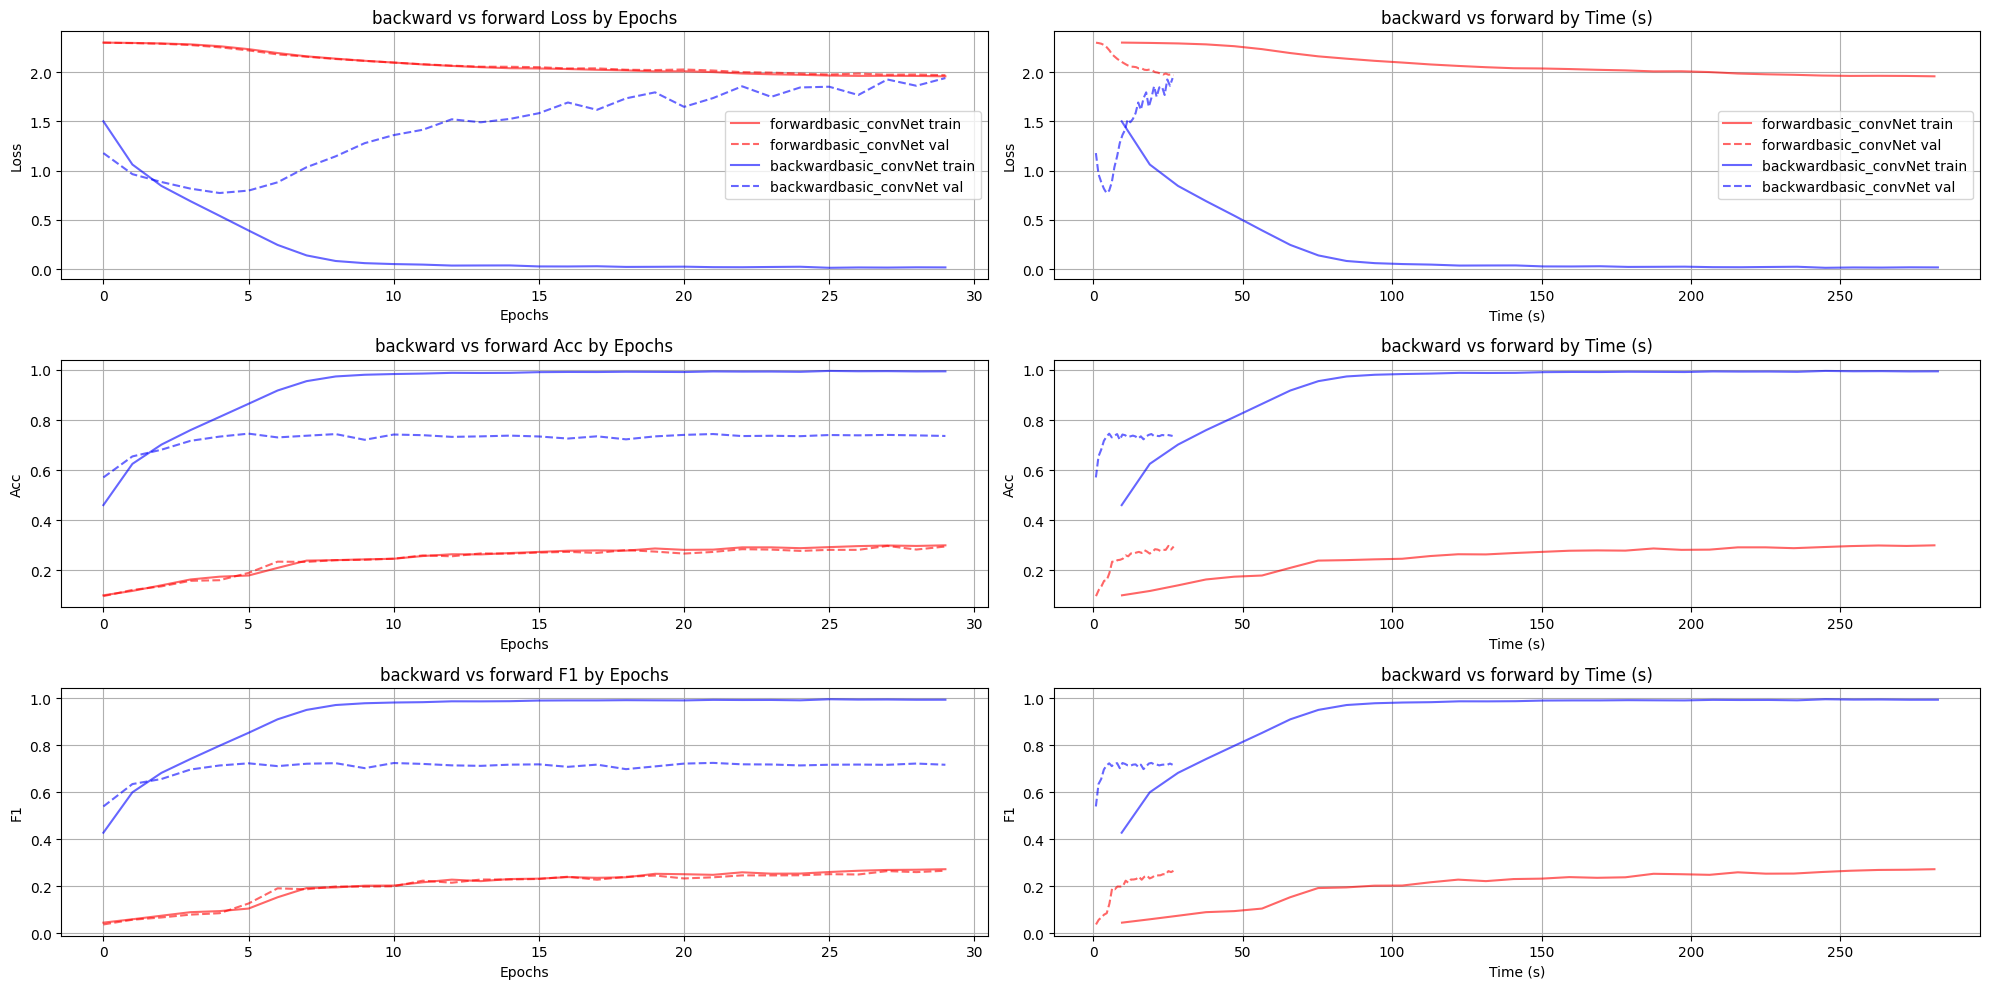

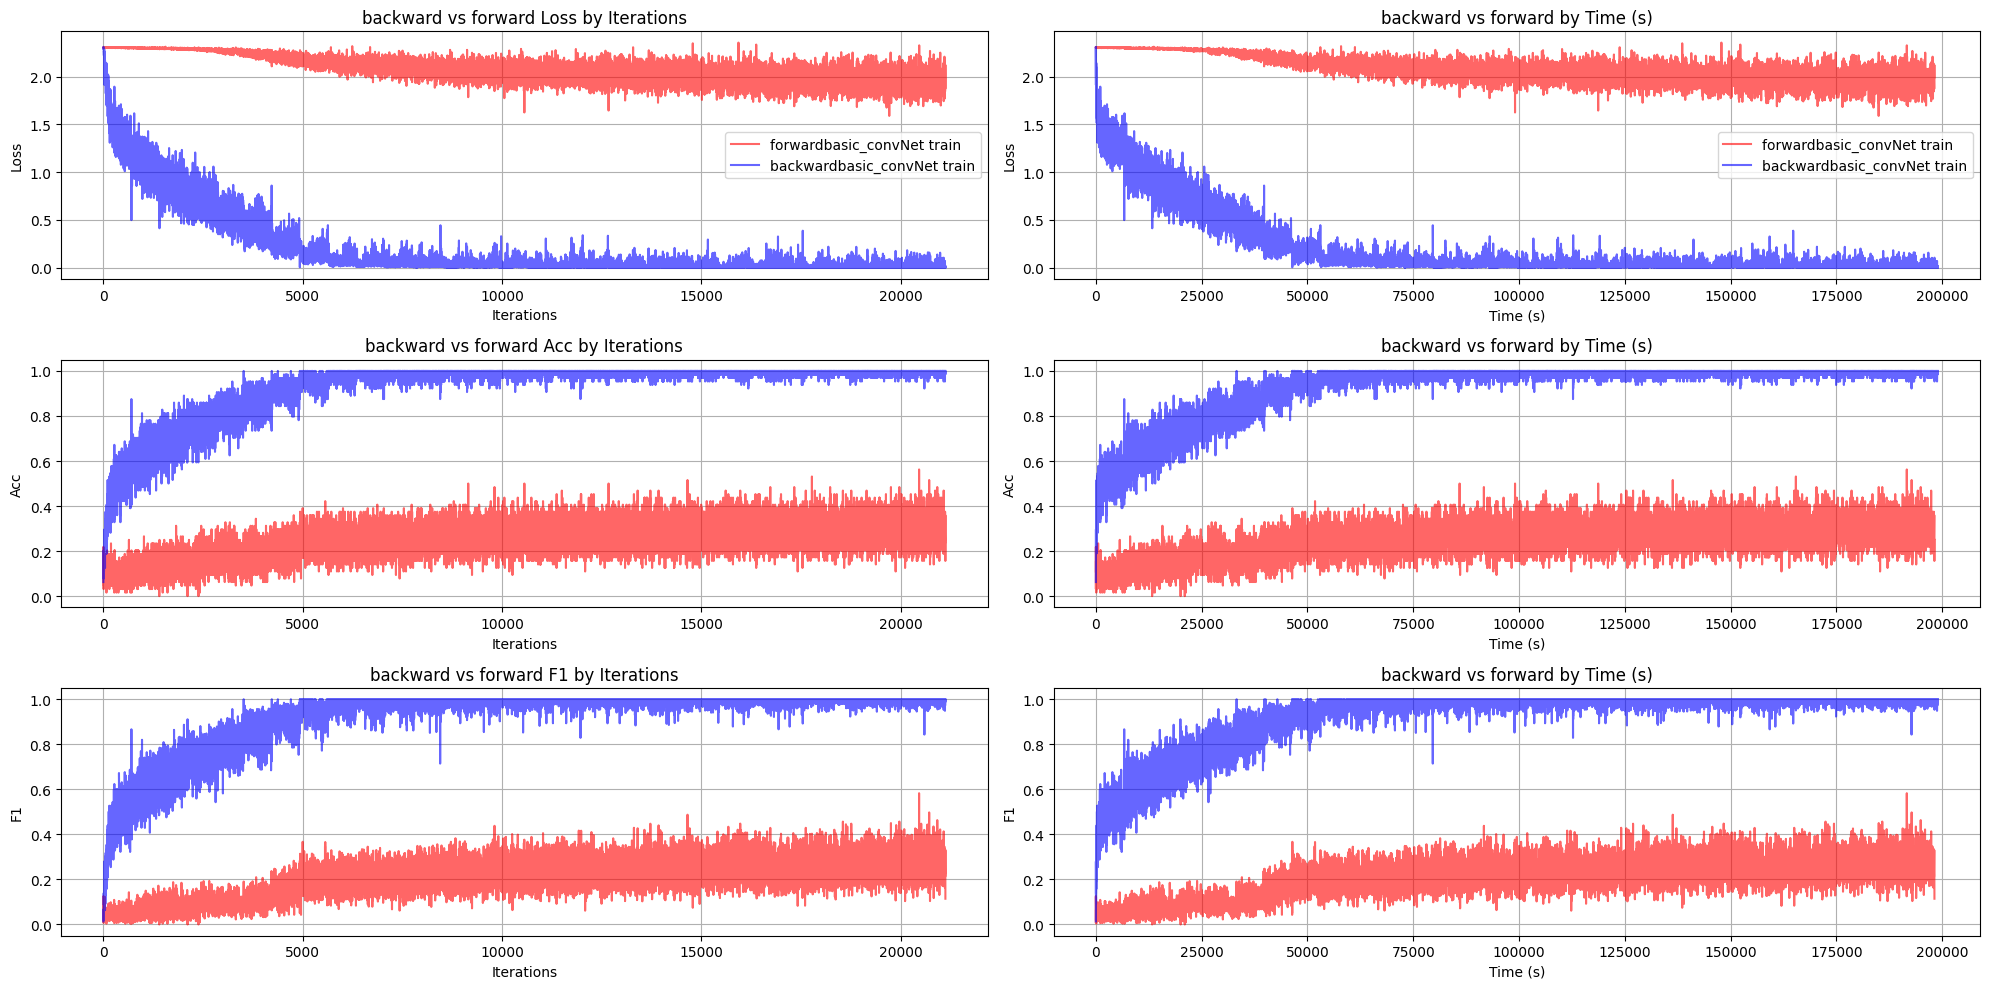

In [8]:
plot_train_valid(train_run_epochs, "basic_convNet", "Epochs", val_run_epochs)
plot_train_valid(train_run_its, "basic_convNet", "Iterations")

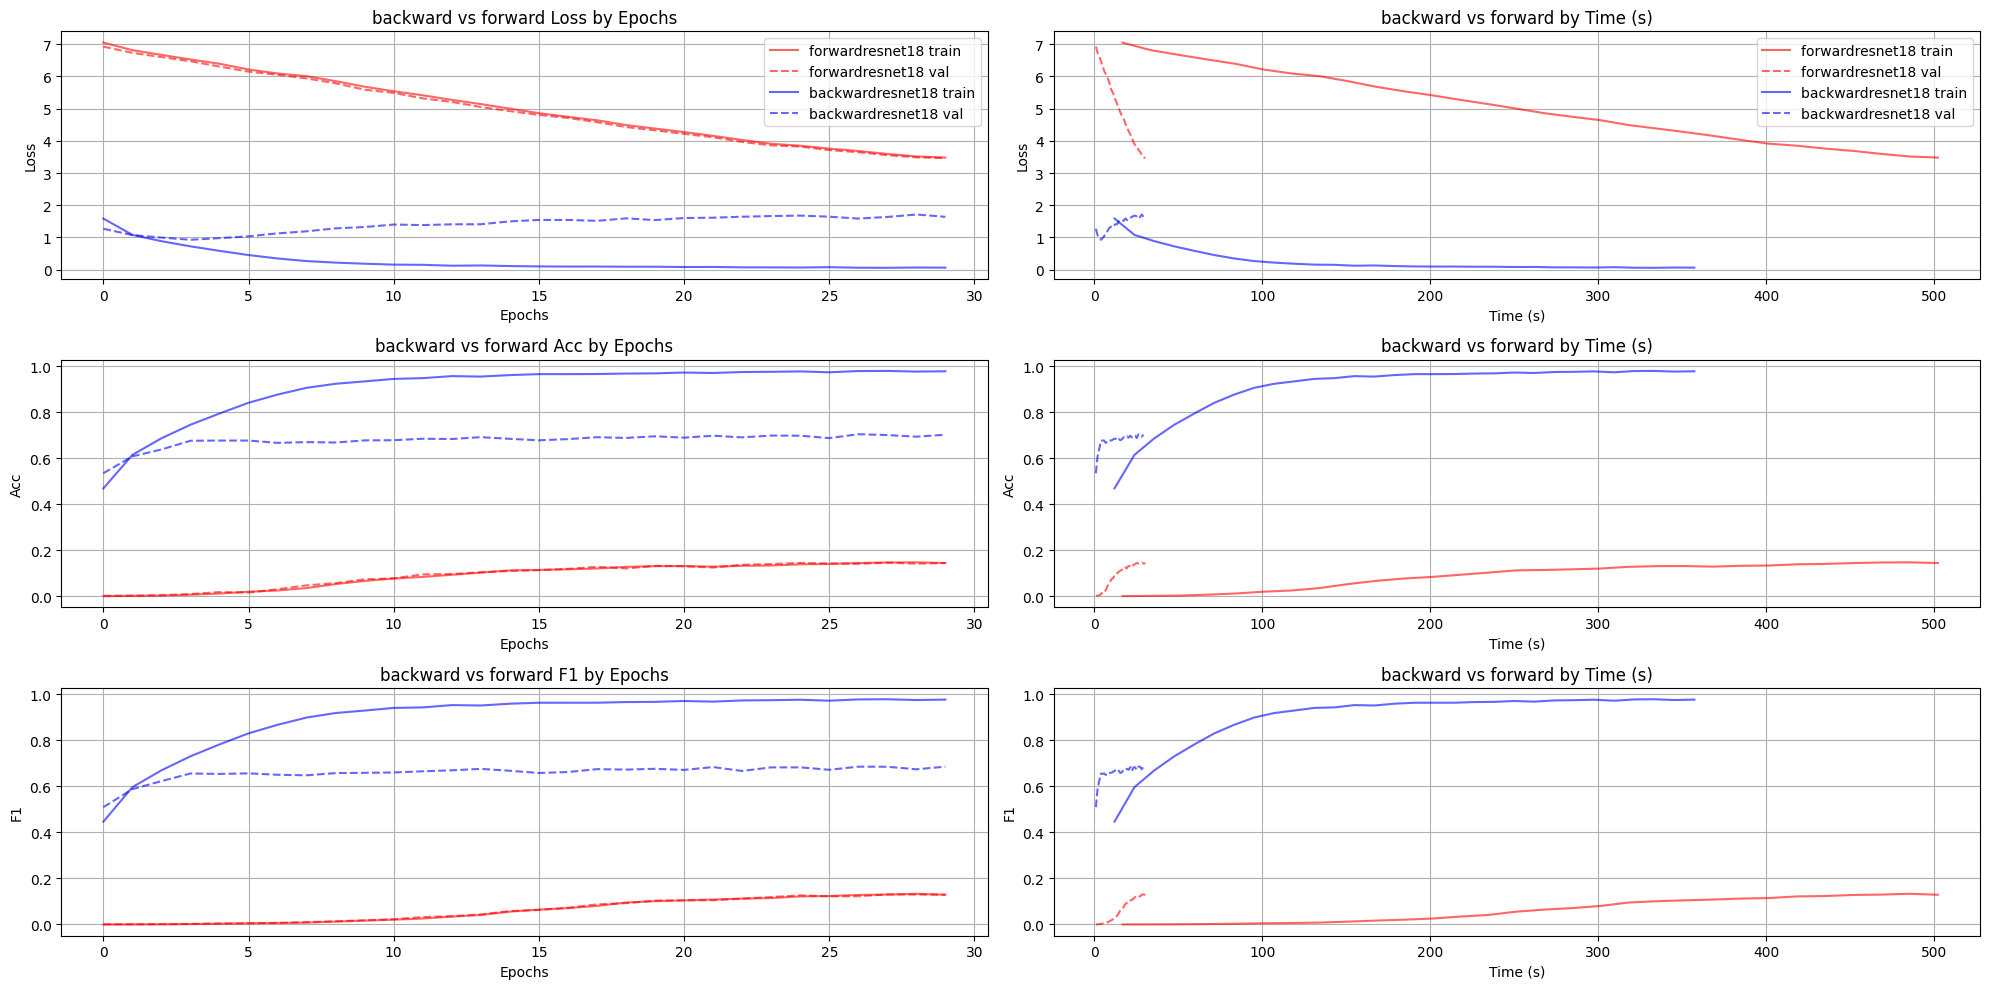

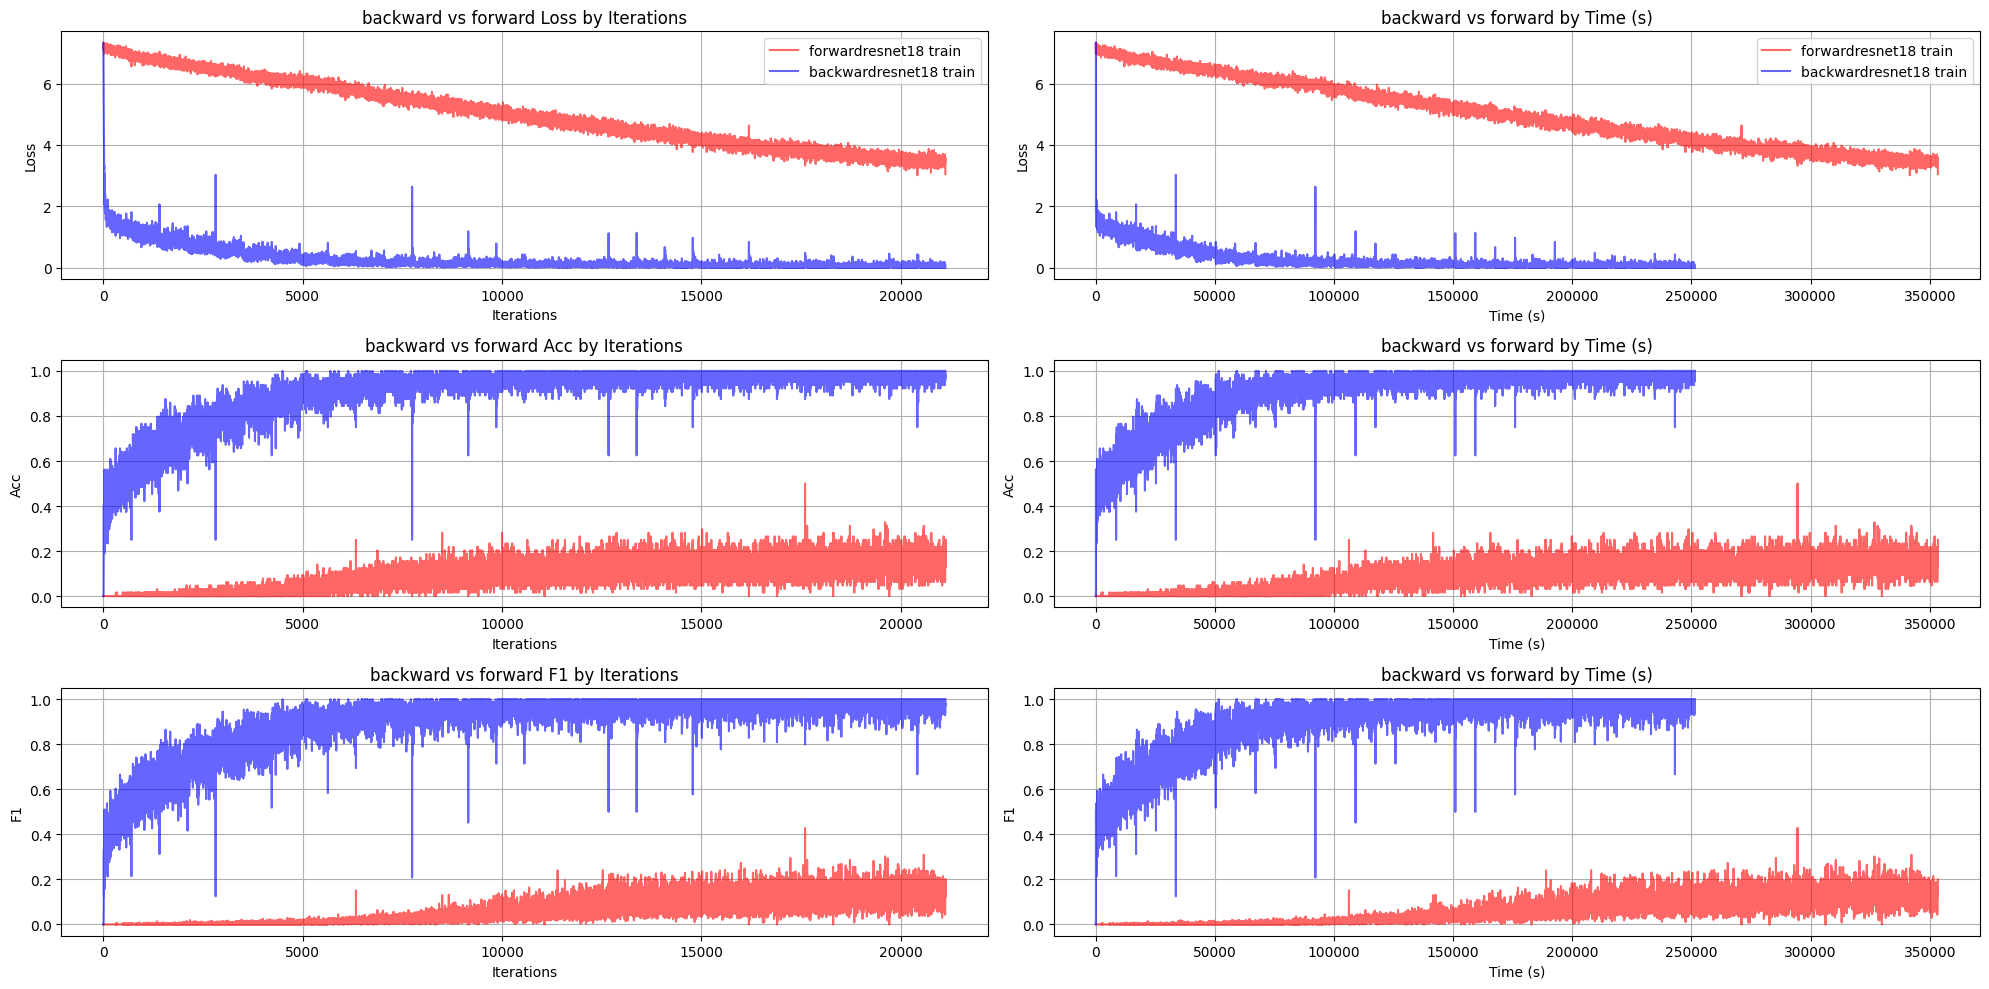

In [9]:
plot_train_valid(train_run_epochs, "resnet18", "Epochs", val_run_epochs)
plot_train_valid(train_run_its, "resnet18", "Iterations")

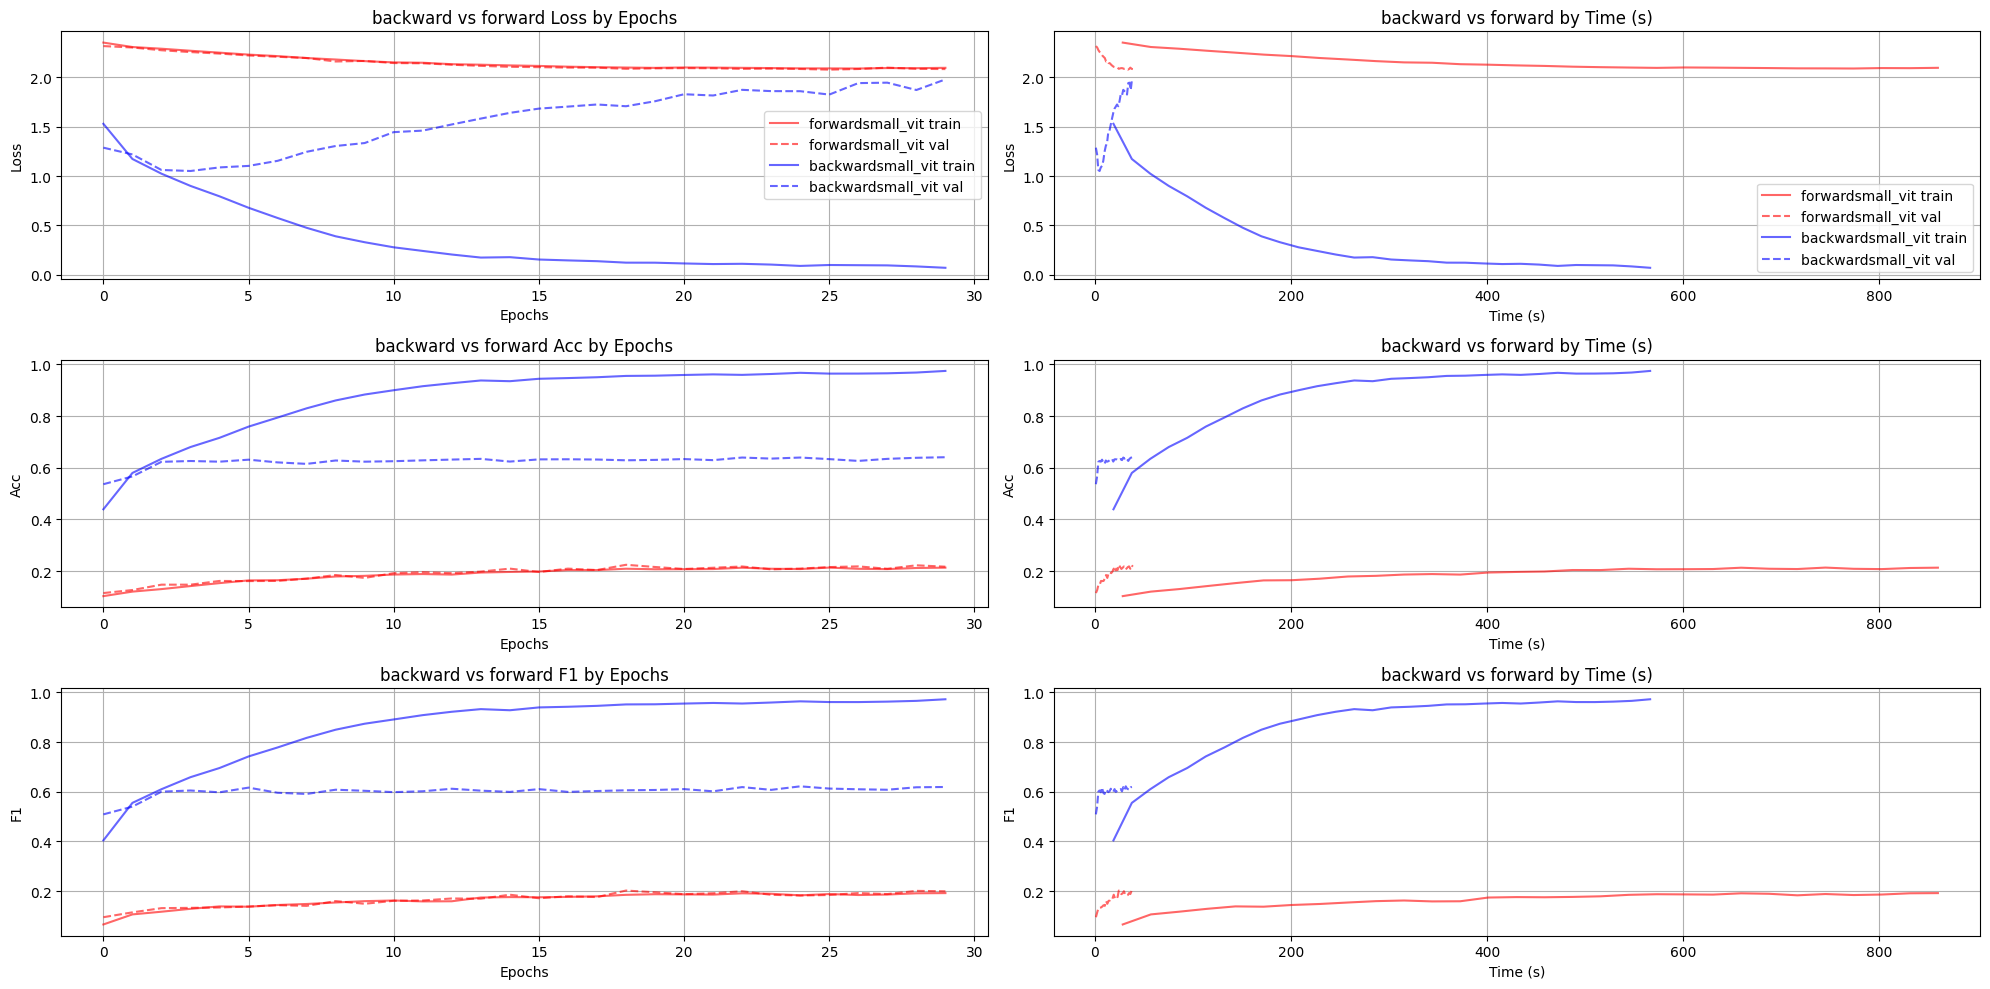

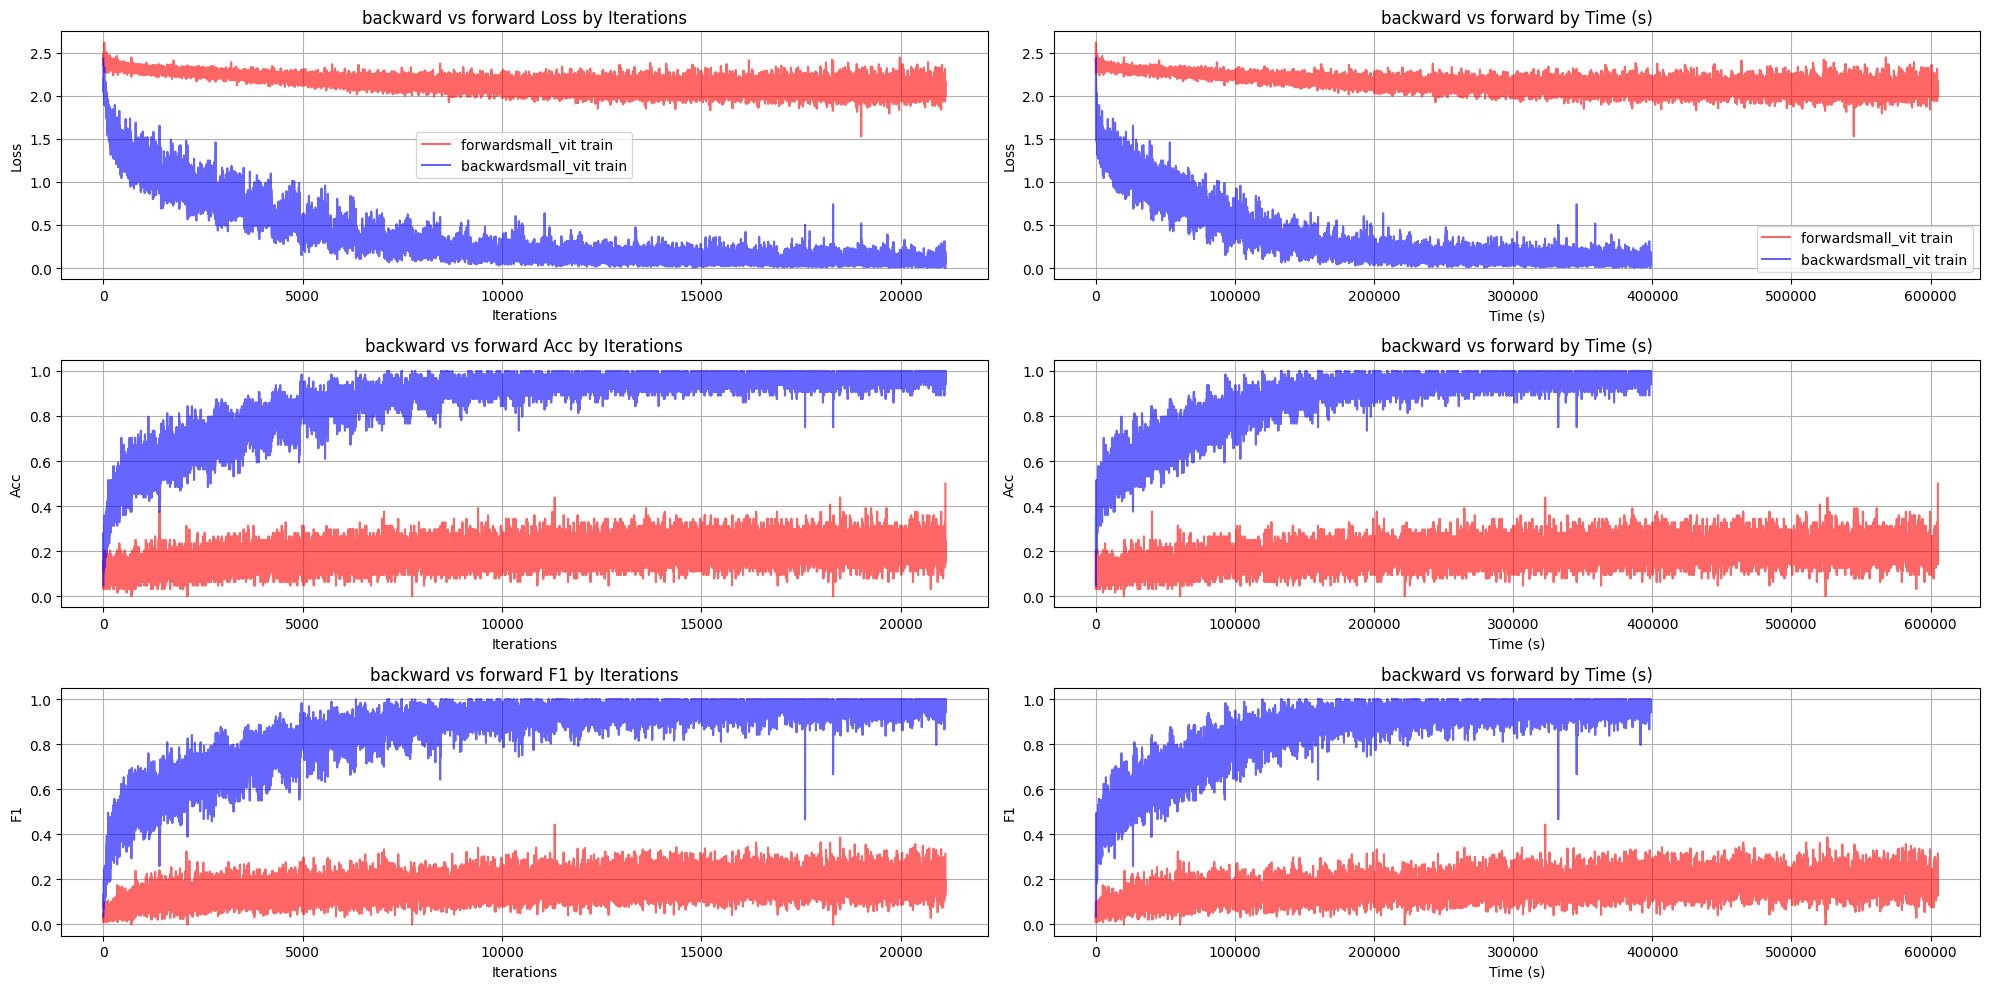

In [10]:
plot_train_valid(train_run_epochs, "small_vit", "Epochs", val_run_epochs)
plot_train_valid(train_run_its, "small_vit", "Iterations")

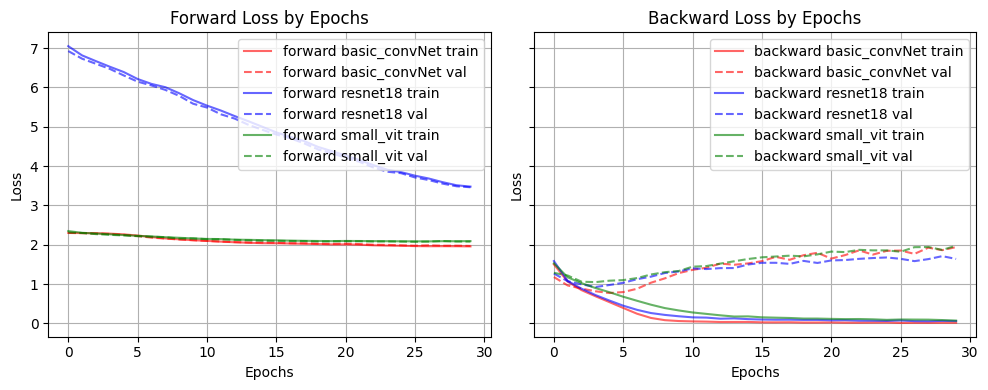

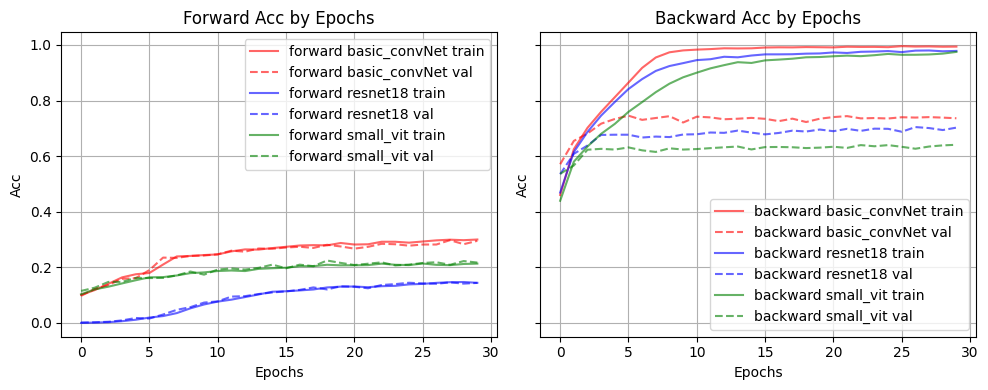

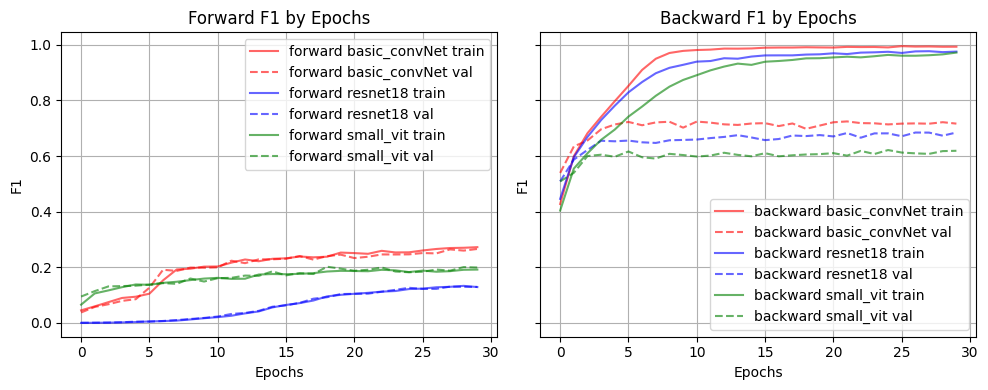

In [16]:
plot_comparison(train_run_epochs, run_path_forward.keys(),val_run_epochs)